In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P


##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'pall' : pall,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,        
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [555]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax'])
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
        'pall' : pall,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [556]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [557]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [558]:
obs_gpmf.head()

prcp       q925      q650       t925  \
0  33.945941  16.032429  5.258263  21.451288   
1   4.216382  13.945688  6.594621  21.226892   
2  59.185143  14.722182  4.939521  24.223535   
3   2.248306  17.130347  6.434912  21.410577   
4  43.297786  16.088208  5.281735  27.334863   

                                                pall      shear  month  \
0  [0.10314908445050522, 0.11213220449627026, 0.1...  21.597702      9   
1  [0.04182065917067548, 0.012917569451466774, 0....  -3.408928      8   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  20.380962      7   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  18.177017      8   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47585907...  20.113298      6   

     area       tmin         rh    theta_e   theta_es       tcwv     tgrad  \
0    6350 -80.861286  92.476395   5.352094   9.537061  50.086918  0.174528   
1    9500 -66.841842  80.737831   0.152769  10.020525  47.465511  0.115285   
2  109950 -84.518429  71.706879   4.475381  23.200466  46.883617  0.169490   
3   19025 -69.398859  99.019821  13.786762  14.390733  59.113689  0.239586   
4  190925 -88.485493  65.269966  13.391944  42.317307  48.521294  0.178521   

       tbox        lat        lon  
0  3.371307  15.337195 -11.309676  
1  0.348175  11.320022 -12.558099  
2  4.454224  15.367470 -12.196891  
3  0.140045  17.328758 -12.240657  
4  4.899445  11.785741   6.625053

In [559]:
tmeans = []
for m in np.unique(obs_gpmf.month):
    #ipdb.set_trace()
    pos = np.where(obs_gpmf.month.values==m)
    tmeans.append(np.mean(obs_gpmf.tmin.values[pos]))

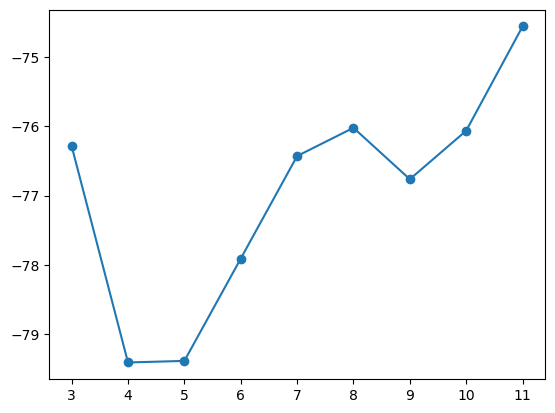

In [560]:
plt.plot(np.unique(obs_gpmf.month), tmeans, marker='o')

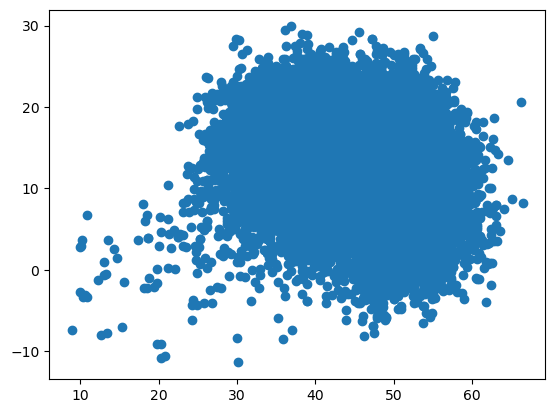

In [561]:
plt.scatter(obs_gpmf.tcwv, obs_gpmf.shear)

In [562]:
futf['theta_e']

0         5.521202
1         6.515116
2         3.830775
3         4.052897
4         3.749018
           ...    
10228     6.755763
10229     6.637091
10230    16.394919
10231    13.086865
10232    12.657282
Name: theta_e, Length: 99291, dtype: float64

In [563]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.998084590200353


In [564]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-12,12,9,18]  # 8.5, 17.5
domainWA = [-13,13,4,20]
domainOuaga = [-3.5,2,11,13.5]
nb = 25
region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(5,21,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,75,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(6,20,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,80,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-7.9,6,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-7.9,7.9,nb), np.linspace(20,92,nb)],
         }

domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 5 #5
m2 = 10 #10
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2) ] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [565]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -11.76275634765625 11.990509033203125
OBS_gpm 9.000161827841007 17.74562661158754 -11.996923725377139 11.996942654145766


In [566]:
len(obs_gpm)

29392

In [567]:
np.mean(hist['tcwv'])

43.078976843601716

In [568]:
np.mean(fut['tcwv'])

62.363163245961566

In [569]:
np.mean(fut['t925'])-np.mean(hist['t925'])

5.714704994041178

In [570]:
(np.mean(fut['q925'])-np.mean(hist['q925']))/np.mean(hist['q925'])  / (np.mean(fut['t925'])-np.mean(hist['t925']))   ### CC scaling with q925 in CP4 is ~ 0.062

0.05684757518239373

In [571]:
(np.mean(fut['tcwv'])-np.mean(hist['tcwv']))/np.mean(hist['tcwv'])  / (np.mean(fut['t925'])-np.mean(hist['t925']))   ### CC scaling in CP4 is ~ 0.062 

0.07833252477988314

In [572]:
 np.mean(fut['t925'])-np.mean(hist['t925'])

5.714704994041178

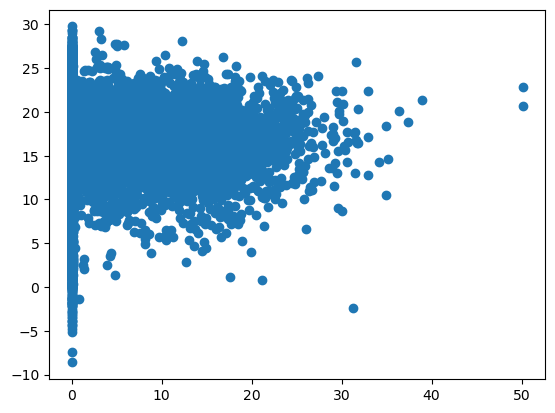

In [573]:
plt.scatter(hist.tgrad, hist.shear)

Text(0.5, 1.0, '-0.56')

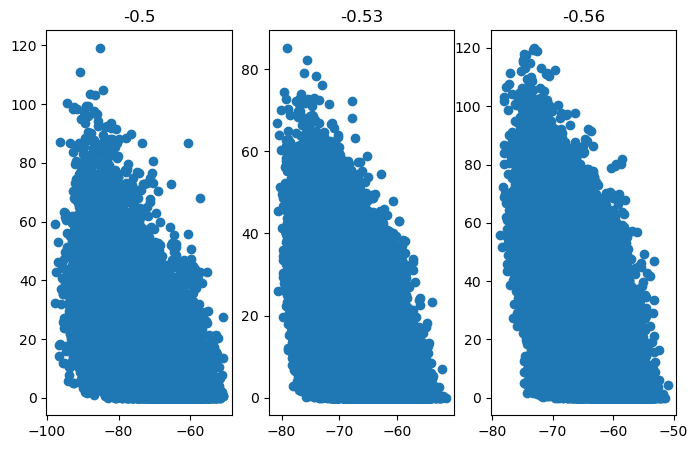

In [574]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5, 1.0, '0.14')

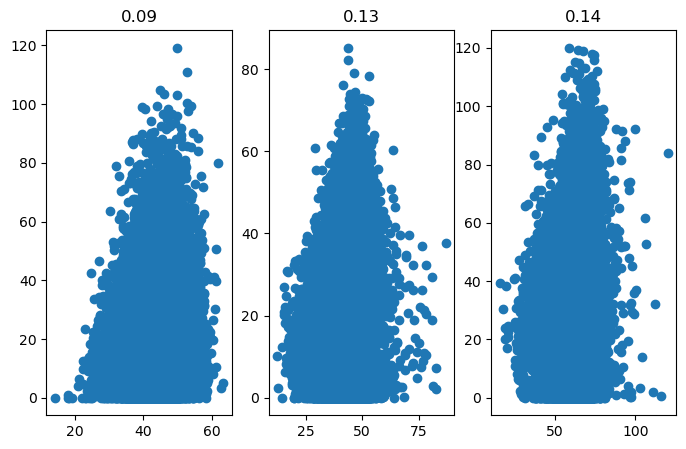

In [575]:

cp4s = [obs_gpm.tcwv, obs_gpm.prcp] # gpm
cp25s = [hist.tcwv, hist.prcp] #cp4
futur = [fut.tcwv, fut.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [576]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [577]:
oposi =  (obs_gpm.q925>=8.) & (obs_gpm.prcp>=8) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.shear>0) & (obs_gpm.tmin<=-55)  # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #(obs_gpm.q925>=9.) & (obs_gpm.shear>-5) & 
cposi =   (hist.q925>=8.) &(hist.prcp>=8)  & (hist.theta_e>=-40) & (np.isfinite(hist.q925)) & (hist.shear>0)  & (hist.area>=5000) & (hist.tmin<=-55)  #(hist.q925>=9.) & (hist.shear>-5) &
fposi =  (fut.q925>=8.) &(fut.prcp>=8)  & (fut.theta_e>=-40) & (np.isfinite(fut.q925)) & (fut.shear>0)  & (fut.area>=5000) & (fut.tmin<=-55)   #(fut.q925>=9.) & (fut.shear>-5) & 

In [578]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [579]:
#pickle.dump(obs, open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "wb"))
# pickle.dump(cp4, open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "wb"))
# pickle.dump(cp4f, open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "wb"))

In [580]:
np.percentile(cp4f.tcwv, 0.05)

30.895443629185376

In [581]:
np.percentile(obs['tcwv'],0.025)

24.996283096313476

In [666]:
np.percentile(cp4['tcwv'],0.01)  ### use first percentile to define regions where MCSs can ocurr

18.87009518139449

In [583]:
np.percentile(cp4f['tcwv'],0.025)  ### use first percentile to define regions where MCSs can ocurr

28.93705232533544

In [584]:
np.percentile(cp4f['tcwv'],0.05)  ### use first percentile to define regions where MCSs can ocurr

30.895443629185376

In [585]:
cp4.area.min()

5014.240000000001

In [586]:
(np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))/np.mean(cp4['tcwv'])  / (np.mean(cp4f['t925'])-np.mean(cp4['t925']))   ### CC scaling in CP4 is ~ 0.062

0.07840359943012673

In [587]:
np.mean(cp4f['t925'])-np.mean(cp4['t925'])

5.703916066298433

In [588]:
np.mean(cp4['tcwv'])

43.21070030887553

In [589]:
(np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))/np.mean(cp4['tcwv'])

0.44720755044512656

In [590]:
(np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))

19.3241514381507

In [591]:
(np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))#/np.mean(cp4['tcwv'])

19.3241514381507

In [592]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY.csv', index_col=0)
    #ipdb.set_trace()
    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear'])*-1)
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')
cp4_shear_diff = (cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear'])#/cp4_df.loc['CP4hist', 'shear']*100
cp25_shear_diff = (cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear'])#/cp4_df.loc['CP25hist', 'shear']*100

cp4_tcwv_diff = (cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv'])#/cp4_df.loc['CP4hist', 'tcwv']*100
cp25_tcwv_diff = (cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv'])#/cp4_df.loc['CP25hist', 'tcwv']*100
cp4_tcwv_hist = cp4_df.loc['CP4hist', 'tcwv']

In [593]:
cp4_tcwv_hist

array([40.219635])

In [594]:
obs.area.min()

5225

In [595]:
len(obs)

22368

In [596]:
len(cp4)

45977

In [597]:
len(cp4f)

35977

In [598]:
print(np.mean(cp4.tcwv))

43.21070030887553


In [599]:
np.percentile(cp4f.tcwv,0.01)

26.32812824996723

In [600]:
print(np.mean(cp4f.shear))

16.758931248896946


In [601]:
out_cp4 = {}
out_cp4f = {}

for k in ['prcp','tcwv', 'shear', 'tgrad']:
    out_cp4[k] = cp4[k]
    out_cp4f[k] = cp4f[k]

In [476]:
cp4f_csv = pd.DataFrame.from_dict(out_cp4f)
cp4_csv = pd.DataFrame.from_dict(out_cp4)

In [477]:
# cp4f_csv.to_csv('/home/ck/DIR/cornkle/figs/ENDGAME/cp4_csv/cp4f.csv')
# cp4_csv.to_csv('/home/ck/DIR/cornkle/figs/ENDGAME/cp4_csv/cp4.csv')

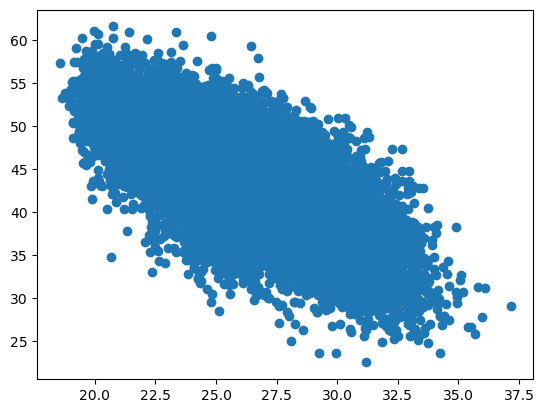

In [478]:
plt.scatter(obs['t925'], obs['tcwv'])

In [479]:
np.min(obs['tcwv'])

22.560836791992188

In [480]:
len(cp4f['tcwv'])

35977

In [481]:
len(cp4['tcwv'])

45977

In [482]:
cp4f['tcwv']-cp4['tcwv']

1148    NaN
1149    NaN
1150    NaN
1151    NaN
1152    NaN
         ..
15107   NaN
15115   NaN
15117   NaN
15127   NaN
15128   NaN
Name: tcwv, Length: 152595, dtype: float64

In [483]:
from endgame import hist2d
p_tcw = hist2d.var2_binning_percentile(obs_gpm.tcwv, obs_gpm.prcp, np.linspace(27,55,15), 95)
pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(p_tcw['xbins'], p_tcw['y'])
tir_tcw = hist2d.var2_binning_percentile(obs_gpm.shear, obs_gpm.prcp, np.linspace(6,17,15), 95)
tslope, tintercept, tr_value, tp_value, tstd_err = stats.linregress(tir_tcw['xbins'], tir_tcw['y'])

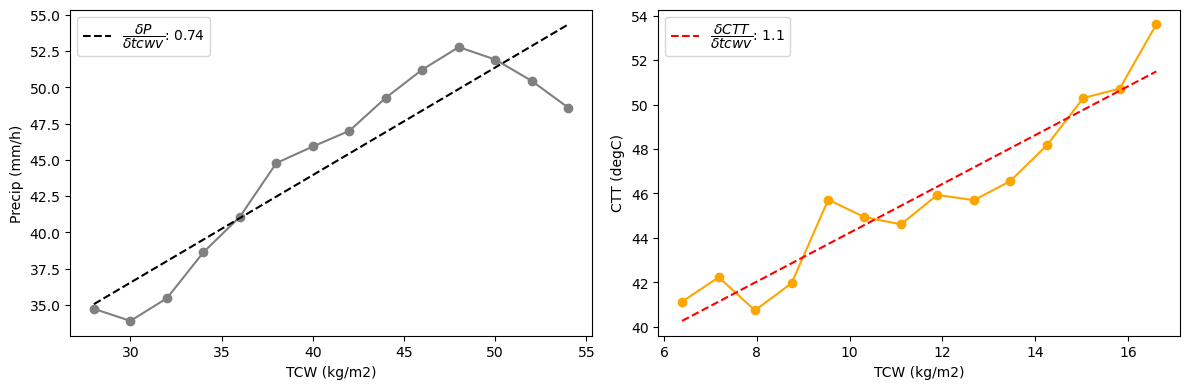

In [484]:
f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(121)
plt.plot(p_tcw['xbins'], p_tcw['y'], color='grey', marker='o')
plt.plot(p_tcw['xbins'], pintercept+np.array(p_tcw['xbins'])*pslope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tcwv}$: ' + str(np.round(pslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Precip (mm/h)')
plt.legend()

ax = f.add_subplot(122)
plt.plot(tir_tcw['xbins'], tir_tcw['y'], color='orange', marker='o')
plt.plot(tir_tcw['xbins'], tintercept+np.array(tir_tcw['xbins'])*tslope, linestyle='dashed', color='r', label=r'$\dfrac{\delta CTT}{\delta tcwv}$: ' + str(np.round(tslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('CTT (degC)')
plt.legend()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_UM-5km_Sahel_averageScaling_TCWbin.jpg')

In [485]:
obs_basic = hist2d.basic_1d_binning(obs['tcwv'], np.arange(np.min(obs['tcwv']), np.max(obs['tcwv']),1))
cp4_basic = hist2d.basic_1d_binning(cp4['tcwv'], np.arange(np.min(cp4['tcwv']), np.max(cp4['tcwv']),1))
cp4f_basic = hist2d.basic_1d_binning(cp4f['tcwv'], np.arange(np.min(cp4f['tcwv']), np.max(cp4f['tcwv']),1))

In [486]:
obs_basic_shear = hist2d.basic_1d_binning(obs['shear'], np.arange(np.min(obs['shear']), np.max(obs['shear']),1))
cp4_basic_shear = hist2d.basic_1d_binning(cp4['shear'], np.arange(np.min(cp4['shear']), np.max(cp4['shear']),1))
cp4f_basic_shear = hist2d.basic_1d_binning(cp4f['shear'], np.arange(np.min(cp4f['shear']), np.max(cp4f['shear']),1))

In [487]:
obs_basic_pr = hist2d.basic_1d_binning(obs['prcp'], np.arange(np.min(obs['prcp']), np.max(obs['prcp']),1))
cp4_basic_pr = hist2d.basic_1d_binning(cp4['prcp'], np.arange(np.min(cp4['prcp']), np.max(cp4['prcp']),1))
cp4f_basic_pr = hist2d.basic_1d_binning(cp4f['prcp'], np.arange(np.min(cp4f['prcp']), np.max(cp4f['prcp']),1))

In [488]:
high = (obs['prcp'])[(obs['lat']>16) & (obs['lat']<19)]
mid = (obs['prcp'])[(obs['lat']<16)&(obs['lat']>12)]
low = (obs['prcp'])[(obs['lat']>9)&(obs['lat']<12)]

hight = (obs['tcwv'])[(obs['lat']>16) & (obs['lat']<19)]
midt = (obs['tcwv'])[(obs['lat']<16)&(obs['lat']>12)]
lowt = (obs['tcwv'])[(obs['lat']>9)&(obs['lat']<12)]

highs = (obs['shear'])[(obs['lat']>16) & (obs['lat']<19)]
mids = (obs['shear'])[(obs['lat']<16)&(obs['lat']>12)]
lows = (obs['shear'])[(obs['lat']>9)&(obs['lat']<12)]

cp4_high = hist2d.basic_1d_binning(high, np.arange(5, 90,1))
cp4_mid = hist2d.basic_1d_binning(mid, np.arange(5, 90,1))
cp4_low = hist2d.basic_1d_binning(low, np.arange(5, 90,1))

cp4_hight = hist2d.basic_1d_binning(hight, np.arange(5, 90,1))
cp4_midt = hist2d.basic_1d_binning(midt, np.arange(5, 90,1))
cp4_lowt = hist2d.basic_1d_binning(lowt, np.arange(5, 90,1))

cp4_highs = hist2d.basic_1d_binning(highs, np.arange(5, 90,1))
cp4_mids = hist2d.basic_1d_binning(mids, np.arange(5, 90,1))
cp4_lows = hist2d.basic_1d_binning(lows, np.arange(5, 90,1))

p_high = np.percentile(high, np.arange(1,101,5))
p_mid = np.percentile(mid, np.arange(1,101,5))
p_low = np.percentile(low, np.arange(1,101,5))

p_hight = np.percentile(hight, np.arange(1,101,5))
p_midt = np.percentile(midt, np.arange(1,101,5))
p_lowt = np.percentile(lowt, np.arange(1,101,5))

p_highs = np.percentile(highs, np.arange(1,101,5))
p_mids = np.percentile(mids, np.arange(1,101,5))
p_lows = np.percentile(lows, np.arange(1,101,5))

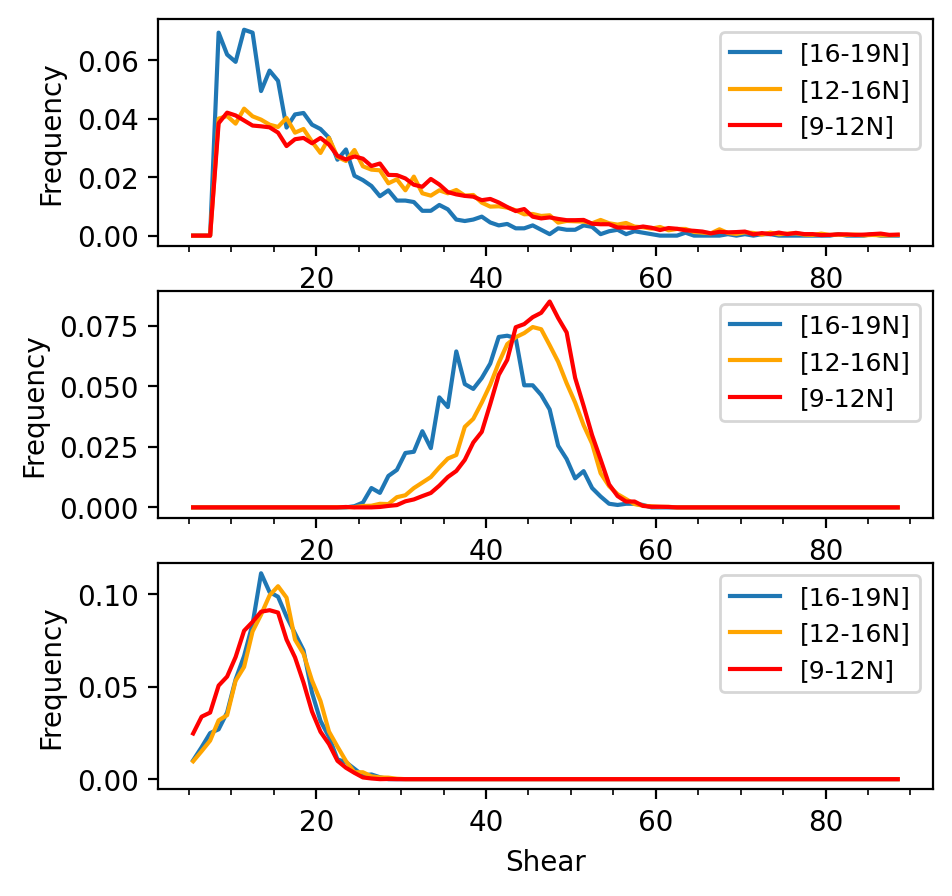

In [489]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(cp4_high['xbins'], cp4_high['nb']/np.sum(cp4_high['nb']), label='[16-19N]')
plt.plot(cp4_mid['xbins'], cp4_mid['nb']/np.sum(cp4_mid['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_low['xbins'], cp4_low['nb']/np.sum(cp4_low['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Precip')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(cp4_hight['xbins'], cp4_hight['nb']/np.sum(cp4_hight['nb']), label='[16-19N]')
plt.plot(cp4_midt['xbins'], cp4_midt['nb']/np.sum(cp4_midt['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lowt['xbins'], cp4_lowt['nb']/np.sum(cp4_lowt['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('TCW')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(cp4_highs['xbins'], cp4_highs['nb']/np.sum(cp4_highs['nb']), label='[16-19N]')
plt.plot(cp4_mids['xbins'], cp4_mids['nb']/np.sum(cp4_mids['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lows['xbins'], cp4_lows['nb']/np.sum(cp4_lows['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Shear')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

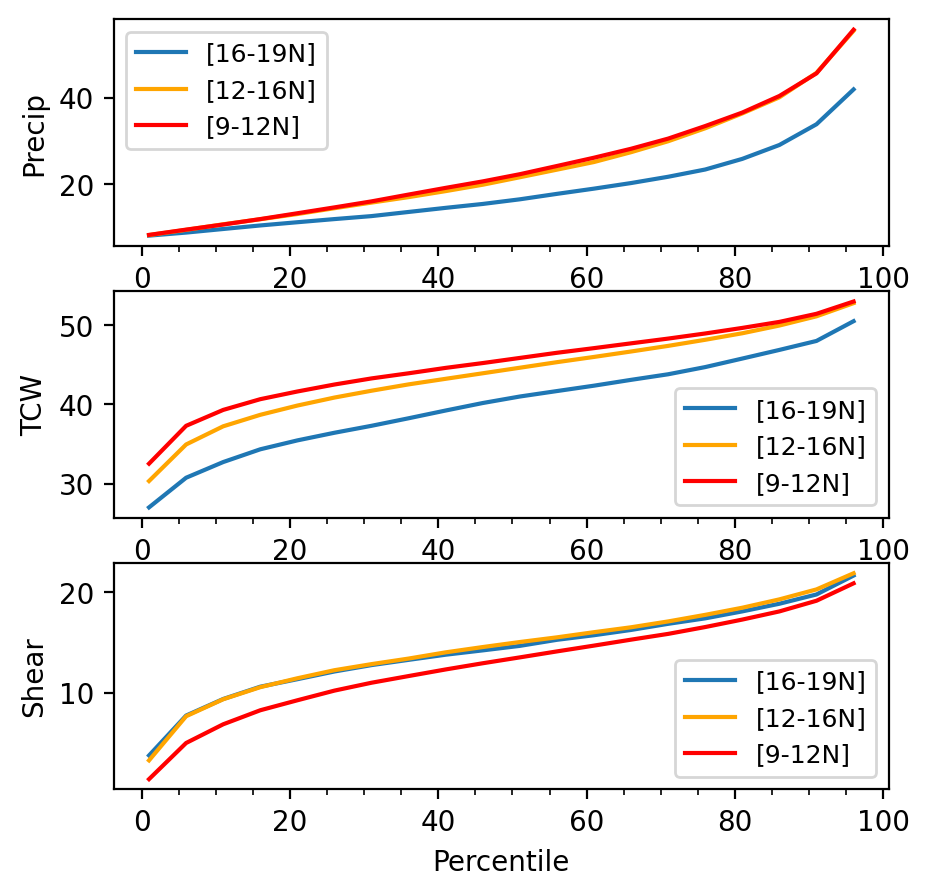

In [490]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(np.arange(1,101,5), p_high, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mid, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_low, color='red', label='[9-12N]')
plt.ylabel('Precip')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(np.arange(1,101,5), p_hight, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_midt, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lowt, color='red', label='[9-12N]')
plt.ylabel('TCW')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(np.arange(1,101,5), p_highs, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mids, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lows, color='red', label='[9-12N]')
plt.ylabel('Shear')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

In [491]:
var = cp4
high = (var['prcp'])[(var['lat']>16) & (var['lat']<19)]
mid = (var['prcp'])[(var['lat']<16)&(var['lat']>12)]
low = (var['prcp'])[(var['lat']>9)&(var['lat']<12)]

hight = (var['tcwv'])[(var['lat']>16) & (var['lat']<19)]
midt = (var['tcwv'])[(var['lat']<16)&(var['lat']>12)]
lowt = (var['tcwv'])[(var['lat']>9)&(var['lat']<12)]

highs = (var['shear'])[(var['lat']>16) & (var['lat']<19)]
mids = (var['shear'])[(var['lat']<16)&(var['lat']>12)]
lows = (var['shear'])[(var['lat']>9)&(var['lat']<12)]

cp4_high = hist2d.basic_1d_binning(high, np.arange(5, 90,1))
cp4_mid = hist2d.basic_1d_binning(mid, np.arange(5, 90,1))
cp4_low = hist2d.basic_1d_binning(low, np.arange(5, 90,1))

cp4_hight = hist2d.basic_1d_binning(hight, np.arange(5, 90,1))
cp4_midt = hist2d.basic_1d_binning(midt, np.arange(5, 90,1))
cp4_lowt = hist2d.basic_1d_binning(lowt, np.arange(5, 90,1))

cp4_highs = hist2d.basic_1d_binning(highs, np.arange(5, 90,1))
cp4_mids = hist2d.basic_1d_binning(mids, np.arange(5, 90,1))
cp4_lows = hist2d.basic_1d_binning(lows, np.arange(5, 90,1))

p_high = np.percentile(high, np.arange(1,101,5))
p_mid = np.percentile(mid, np.arange(1,101,5))
p_low = np.percentile(low, np.arange(1,101,5))

p_hight = np.percentile(hight, np.arange(1,101,5))
p_midt = np.percentile(midt, np.arange(1,101,5))
p_lowt = np.percentile(lowt, np.arange(1,101,5))

p_highs = np.percentile(highs, np.arange(1,101,5))
p_mids = np.percentile(mids, np.arange(1,101,5))
p_lows = np.percentile(lows, np.arange(1,101,5))

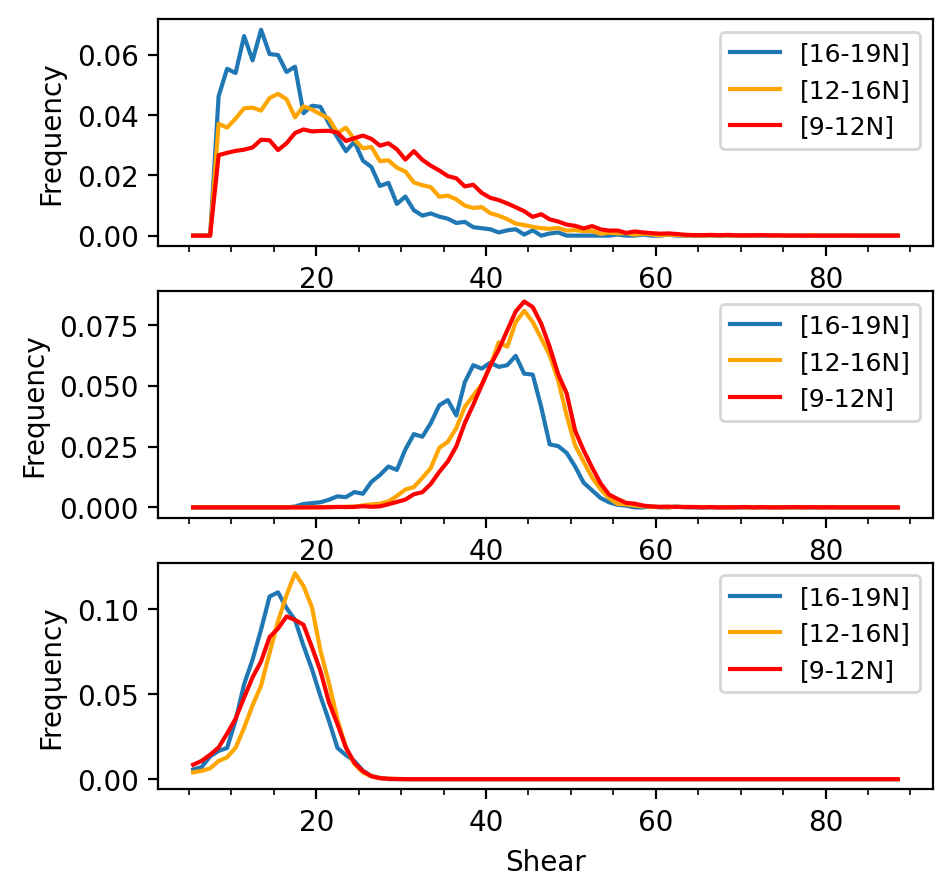

In [492]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(cp4_high['xbins'], cp4_high['nb']/np.sum(cp4_high['nb']), label='[16-19N]')
plt.plot(cp4_mid['xbins'], cp4_mid['nb']/np.sum(cp4_mid['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_low['xbins'], cp4_low['nb']/np.sum(cp4_low['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Precip')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(cp4_hight['xbins'], cp4_hight['nb']/np.sum(cp4_hight['nb']), label='[16-19N]')
plt.plot(cp4_midt['xbins'], cp4_midt['nb']/np.sum(cp4_midt['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lowt['xbins'], cp4_lowt['nb']/np.sum(cp4_lowt['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('TCW')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(cp4_highs['xbins'], cp4_highs['nb']/np.sum(cp4_highs['nb']), label='[16-19N]')
plt.plot(cp4_mids['xbins'], cp4_mids['nb']/np.sum(cp4_mids['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lows['xbins'], cp4_lows['nb']/np.sum(cp4_lows['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Shear')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

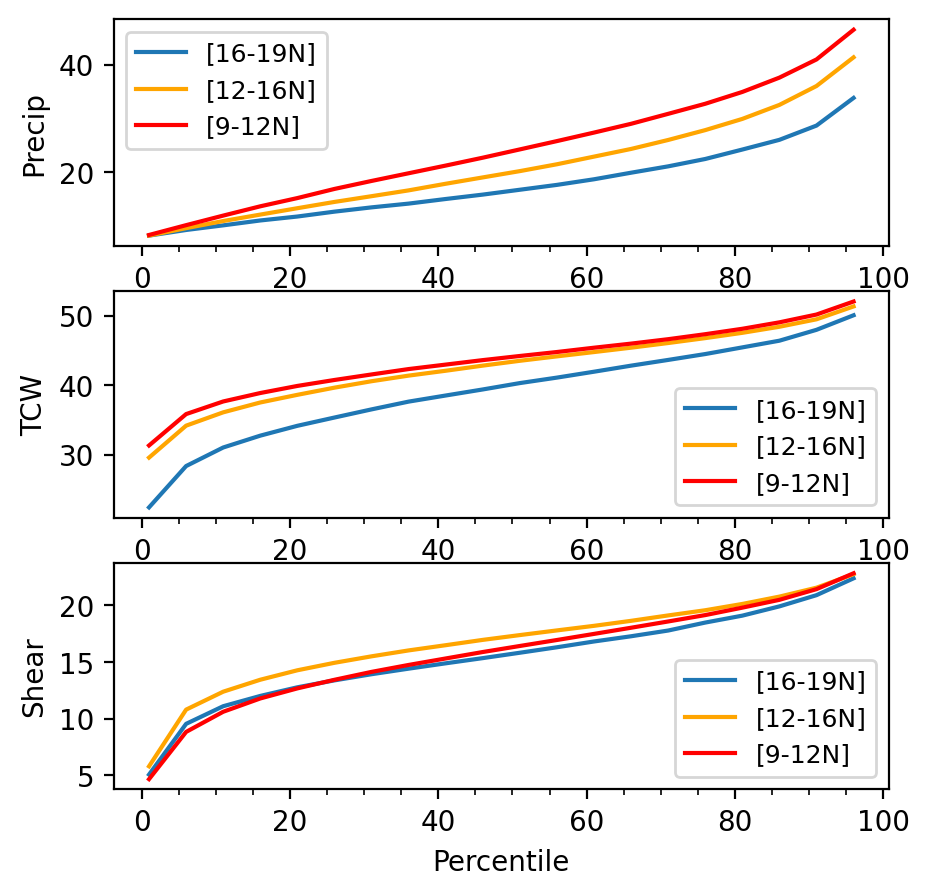

In [493]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(np.arange(1,101,5), p_high, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mid, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_low, color='red', label='[9-12N]')
plt.ylabel('Precip')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(np.arange(1,101,5), p_hight, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_midt, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lowt, color='red', label='[9-12N]')
plt.ylabel('TCW')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(np.arange(1,101,5), p_highs, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mids, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lows, color='red', label='[9-12N]')
plt.ylabel('Shear')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

In [494]:
hmean = []
for pp in cp4['prcp']:
    if np.sum(pp) < 5:
        continue
    hmean.append(np.nanmax(pp))
fmean = []
for pp in cp4f['prcp']:
    if np.sum(pp) < 5:
        continue
    fmean.append(np.nanmax(pp))

In [495]:
fp = np.percentile(fmean,50)
print(fp)
print(stats.percentileofscore(hmean, fp))

32.93807706063331
81.78654544663637


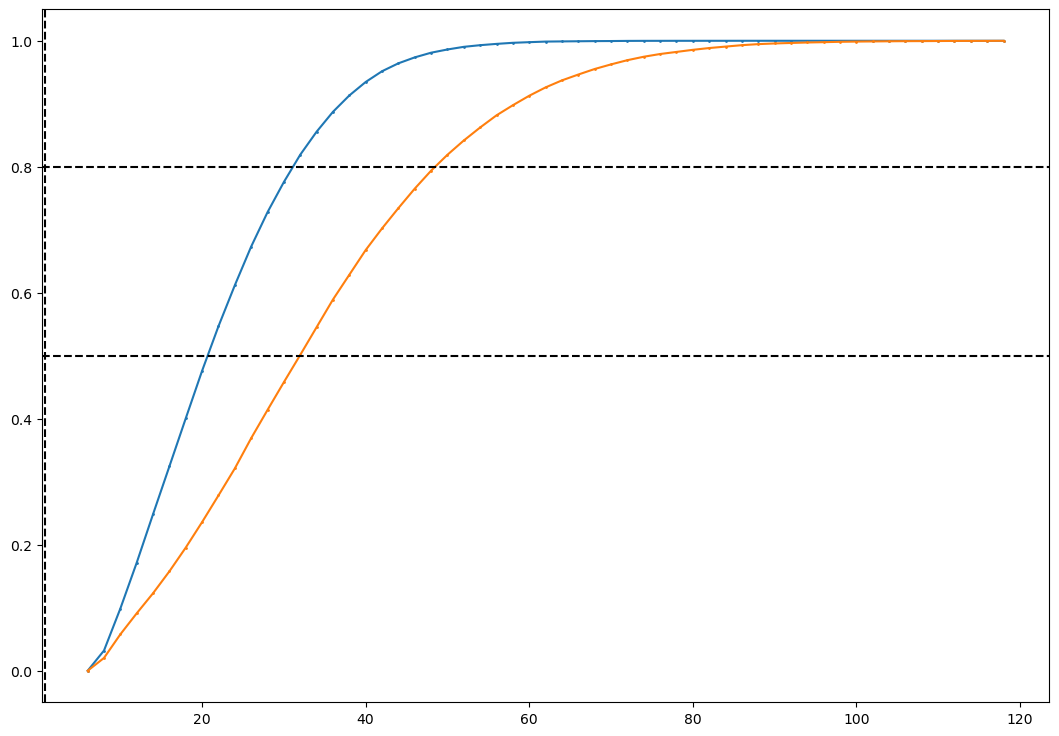

In [612]:
f = plt.figure(figsize=(13,9), dpi=100)
ax = f.add_subplot(111)
#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(hmean, bins=np.arange(5, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulativeh = np.cumsum(nball)
ax.plot(bin_centre,cumulativeh, marker='o', markersize=1)

#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(fmean, bins=np.arange(5, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulativef = np.cumsum(nball)
ax.plot(bin_centre,cumulativef,  marker='o', markersize=1)
plt.axhline(0.5, linestyle='dashed', color='k')
plt.axhline(0.8, linestyle='dashed', color='k')
plt.axvline(0.8, linestyle='dashed', color='k')

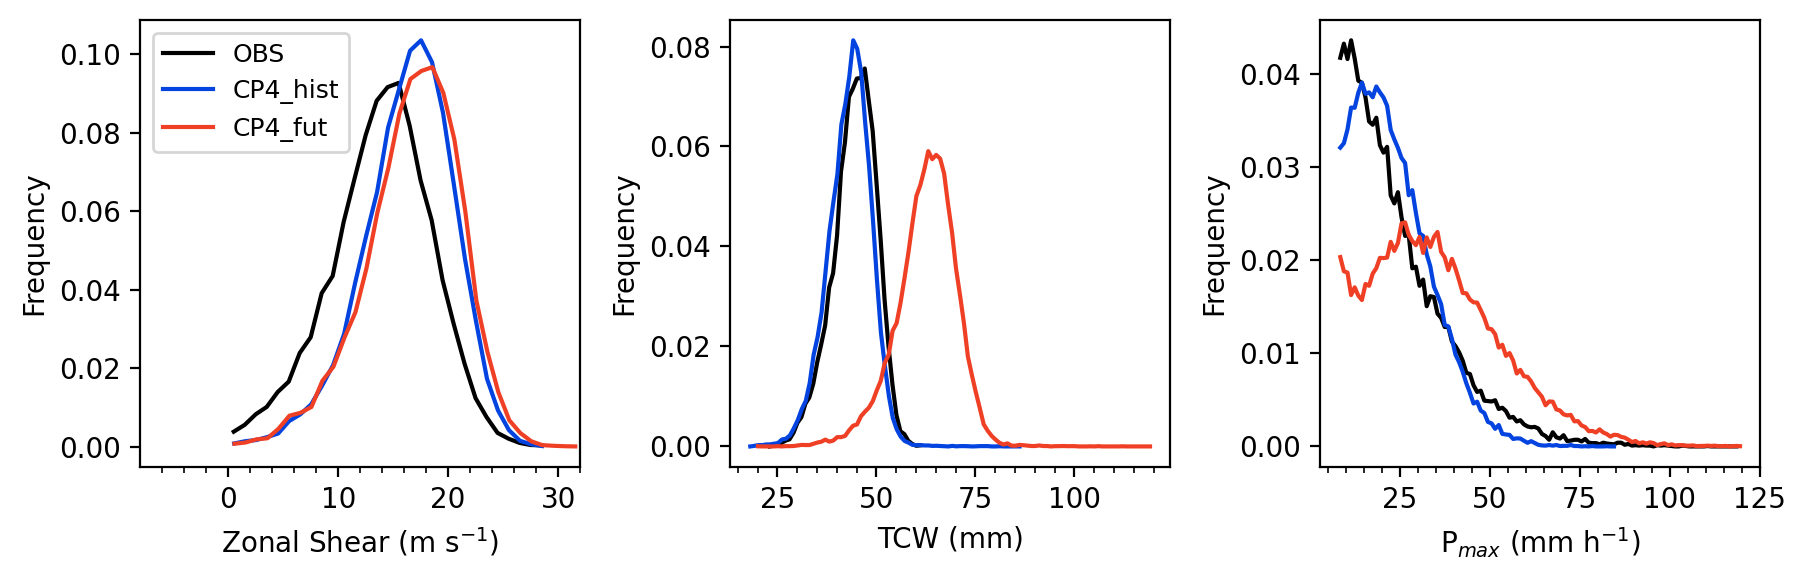

In [621]:
f = plt.figure(figsize=(9,3), dpi=200)
ax = f.add_subplot(131)
plt.plot(obs_basic_shear['xbins'], obs_basic_shear['nb']/np.sum(obs_basic_shear['nb']), label='OBS', color='k')
plt.plot(cp4_basic_shear['xbins'], cp4_basic_shear['nb']/np.sum(cp4_basic_shear['nb']), color='xkcd:blue', label='CP4_hist')
plt.plot(cp4f_basic_shear['xbins'], cp4f_basic_shear['nb']/np.sum(cp4f_basic_shear['nb']), color='xkcd:tomato', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('Zonal Shear (m s$^{-1}$)')
ax.set_xlim(-8,32)
plt.legend(loc='upper left', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')
# for xx in range(5,26,5):
#     plt.axvline(xx, linestyle='dashed', color='slategrey', linewidth=0.5)
ax = f.add_subplot(132)
plt.plot(obs_basic['xbins'], obs_basic['nb']/np.sum(obs_basic['nb']), label='OBS', color='k')
plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='xkcd:blue', label='CP4_hist')
plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='xkcd:tomato', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('TCW (mm)')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(133)
plt.plot(obs_basic_pr['xbins'], obs_basic_pr['nb']/np.sum(obs_basic_pr['nb']), label='OBS', color='k')
plt.plot(cp4_basic_pr['xbins'], cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb']), color='xkcd:blue', label='CP4_hist')
plt.plot(cp4f_basic_pr['xbins'], cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']), color='xkcd:tomato', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('P$_{max}$ (mm h$^{-1}$)')
# ax1 = ax.twinx()
# ax1.plot(cp4_basic_pr['xbins'], (np.array(cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']))[0:80]-(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))/(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

#plt.xlim(19,80)
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/ENDGAME/distribution_'+tag+'_OBS_CP4_driver_'+ttag+'_percentile_8mm.png')

In [498]:

print('Average shear change ABS', np.percentile(cp4f['shear'],50)-np.percentile(cp4['shear'],50))
print('Average shear change REL', (np.median(cp4f['shear'])-np.median(cp4['shear']))/np.median(cp4['shear']))

Average shear change ABS 0.454081632653061
Average shear change REL 0.027179722094976322


In [499]:
print('Average tcwv change ABS', np.median(cp4f['tcwv'])-np.median(cp4['tcwv']))
print('Average shear change REL', (np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))/np.mean(cp4['tcwv']))

Average tcwv change ABS 19.54387606870948
Average shear change REL 0.44720755044512656


In [500]:
print('Average tcwv change ABS', np.array(cp4f['tcwv']).size-np.array(cp4['tcwv']).size)
print('Average shear change REL', (np.array(cp4f['tcwv']).size-np.array(cp4['tcwv']).size)/np.array(cp4['tcwv']).size)

Average tcwv change ABS -10000
Average shear change REL -0.2175000543750136


In [501]:
print(np.median(obs['shear']))
print(np.median(cp4['shear']))
print(np.median(cp4f['shear']))

14.154864311218262
16.706632653061224
17.160714285714285


In [502]:
p = 90
np.percentile(cp4['prcp'][cp4['prcp']>0],p)

37.977339790993256

In [503]:
np.percentile(cp4f['prcp'][cp4f['prcp']>0],p)

59.30190417860753

In [504]:
(np.percentile(cp4f['prcp'][cp4f['prcp']>0],p)-np.percentile(cp4['prcp'][cp4['prcp']>0],p))/np.percentile(cp4['prcp'][cp4['prcp']>0],p)

0.5615075859702956

In [505]:
def read_all(isdata, rainthresh):
    isdata = np.concatenate(np.array(isdata), axis=0)
    isdata = isdata[isdata>rainthresh]
    return isdata

cp4all = np.mean(read_all(cp4['pall'],1))
cp4fall = np.mean(read_all(cp4f['pall'],1))

In [506]:
cp4all

7.341002620872706

In [507]:
cp4fall

9.675550330081064

In [508]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [509]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1]:
            cmap = 'Reds_r'
            
        if i in [3,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_future_50C.png')

In [510]:
vlist = ['prcp', 'area', 'tmin'] # place to change precip input

In [622]:
def get_percentile(x, ttag):
    
    if ttag == 'hourly':
        ptag = [0.1]+list(np.arange(5,96,5))+[99.9]
    else:
        ptag =  [0.1]+list(np.arange(5,96,5))+[99.9]
                         
    return np.percentile(x[np.isfinite(x)], ptag) 

In [623]:
# obs_q925 = hist2d.create_2dhist(obs.shear, obs.q925, get_percentile(obs.shear), get_percentile(obs.q925), obs, vlist)
# obs_theta = hist2d.create_2dhist(obs.shear, obs.theta_e, get_percentile(obs.shear), get_percentile(obs.theta_e), obs, vlist)
# obs_tcwv = hist2d.create_2dhist(obs.shear, obs.tcwv, get_percentile(obs.shear), get_percentile(obs.tcwv), obs, vlist)

# cp4_q925 = hist2d.create_2dhist(cp4.shear, cp4.q925, get_percentile(cp4.shear), get_percentile(cp4.q925), cp4, vlist)
# cp4_theta = hist2d.create_2dhist(cp4.shear, cp4.theta_e,get_percentile(cp4.shear), get_percentile(cp4.theta_e), cp4, vlist)
# cp4_tcwv = hist2d.create_2dhist(cp4.shear, cp4.tcwv, get_percentile(cp4.shear), get_percentile(cp4.tcwv), cp4, vlist)

# cp4f_q925 = hist2d.create_2dhist(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear), get_percentile(cp4f.q925), cp4f, vlist)
# cp4f_theta = hist2d.create_2dhist(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear), get_percentile(cp4f.theta_e), cp4f, vlist)
# cp4f_tcwv = hist2d.create_2dhist(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear), get_percentile(cp4f.tcwv), cp4f, vlist)

In [624]:
percent=95
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, get_percentile(obs.shear, ttag), get_percentile(obs.q925, ttag), obs, vlist, percentile=percent)
obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, get_percentile(obs.shear, ttag), get_percentile(obs.theta_e, ttag), obs, vlist, percentile=percent)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, get_percentile(obs.shear, ttag), get_percentile(obs.tcwv, ttag), obs, vlist, percentile=percent)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, get_percentile(cp4.shear, ttag), get_percentile(cp4.q925, ttag), cp4, vlist, percentile=percent)
cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e,get_percentile(cp4.shear, ttag), get_percentile(cp4.theta_e, ttag), cp4, vlist, percentile=percent)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, get_percentile(cp4.shear, ttag), get_percentile(cp4.tcwv, ttag), cp4, vlist, percentile=percent)

cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.q925, ttag), cp4f, vlist, percentile=percent)
cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.theta_e, ttag), cp4f, vlist, percentile=percent)
cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.tcwv, ttag), cp4f, vlist, percentile=percent)

In [625]:
# percent = 90
# obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, shearbins, qbins, obs, vlist, percent)
# obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, shearbins, thetabins, obs, vlist, percent)
# obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, percent)

# cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist, percent)
# cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, percent)
# cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e, shearbins, thetabins, cp4, vlist, percent)

# cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist, percent)
# cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist,percent)
# cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist, percent)

In [626]:
cp4f_q925.keys()

dict_keys(['prcp', 'prcp_val', 'area', 'area_val', 'tmin', 'tmin_val', 'xbins', 'ybins'])

In [627]:
def plot_dic_tmin(dic, vmin, vmax, xlabel, ylabel, tag):
    
    odic = {
    'data' : dic['tmin'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': minimum temperature',
    'valid' : dic['tmin_val'],
    'cbarlabel' : '${\circ}$C',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_prcp(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['prcp'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': maximum precipitation',
    'valid' : dic['prcp_val'],
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_area(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['area'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': MCS area',
    'valid' : dic['area_val'],
    'cbarlabel' : r'km$^{2}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }    
    return odic

In [628]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [629]:
obs_tcwv.keys()

dict_keys(['prcp', 'prcp_val', 'area', 'area_val', 'tmin', 'tmin_val', 'xbins', 'ybins'])

In [630]:
shape = obs_q925['tmin'].shape
shapet = obs_tcwv['tmin'].shape
# shearscat = binning_hist(shearbins[np.newaxis,:],shape)
# qscat = binning_hist(qbins,shape)
# wvscat = binning_hist(tcwvbins,shapet)
# thetascat = binning_hist(thetabins,shape)

In [631]:
def binning_2dhist(prcp, tmin, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals = []
    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            vals[vals==0] = np.nan
            tvals = tmin[sh==bins]
            tvals[tvals==0] = np.nan
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<3:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals.append(np.sum(np.isfinite(vals)))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],90)) # 75, 25
                    percdown.append(np.percentile(vals[np.isfinite(vals)],10))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                
               
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
            if np.sum(np.isfinite(tvals))<3:
                tt = np.nan
                ttflag=False
            tmean.append(tt)
            
            if ttflag:
                try:
                    tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                    tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
                except:
                    tpercup.append(np.nan)
                    tpercdown.append(np.nan)
            else:
                tpercup.append(np.nan)
                tpercdown.append(np.nan)
                
               
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown, pvals

In [632]:
def run_binning(dic, scat):
    
    binns = np.arange(0,101,5) # collbins
    binns = np.round(binns[0:-1]+((binns[1::]-binns[0:-1])/2),2)
    #ipdb.set_trace()
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)

#     def linregress(bins,data, val):
#         data = np.array(data)
#         pos = np.isfinite(data)
#         val = np.array(val)
#         inbins = bins[pos]
#         indata = data[pos]
#         inval = val[pos]
        
#         slope, intercept, r_value, p_value, std_err = stats.linregress(inbins, indata)
        
#         wlr = sm.OLS(inbins, indata)  #, weights=1./inval
#         p = wlr.fit()
#         print(p.summary())
#         ipdb.set_trace()
#         #p.const + p.motifScore * x
#         return p.motifScore, p.const, 
    
    deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10, pval = binning_2dhist(dic['prcp'], dic['tmin'], scat)
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
    #ipdb.set_trace()
    slope, intercept, r_value, p_value, std_err = linregress(binns, pmean[0:-1], pval[0:-1])
    rslope, rintercept, rr_value, rp_value, rstd_err = linregress(collbins, pmean[0:-1], pval[0:-1])
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pval' : p_value,
        'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'tbox' : tminbox,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'tmean' : tmean[0:-1],
        't90' : t90[0:-1],
        't10' : t10[0:-1],
        'bins' : binns,
        'rbins' : collbins,
        'rslope' : rslope,
        'rintercept' : rintercept,
        'rrval' : rr_value,
        'rpval' : rp_value,
        'rstd_err' : rstd_err
    }
    
    return odic

In [633]:
obs_tcwv_shear = run_binning(obs_tcwv,binning_hist(get_percentile(obs.shear, ttag)[np.newaxis,:],shape))
cp4_tcwv_shear = run_binning(cp4_tcwv,binning_hist(get_percentile(cp4.shear, ttag)[np.newaxis,:],shape))
cp4f_tcwv_shear = run_binning(cp4f_tcwv,binning_hist(get_percentile(cp4f.shear, ttag)[np.newaxis,:],shape))

# obs_tcwv_shear = run_binning(obs_tcwv,get_percentile(obs.shear))
# cp4_tcwv_shear = run_binning(cp4_tcwv,get_percentile(cp4.shear))
# cp4f_tcwv_shear = run_binning(cp4f_tcwv,get_percentile(cp4f.shear))


# obs_shear_q = run_binning(obs_q925,get_percentile(obs.q925))
# cp4_shear_q = run_binning(cp4_q925,get_percentile(cp4.q925))
# cp4f_shear_q = run_binning(cp4f_q925,get_percentile(cp4f.q925))

obs_shear_tcwv = run_binning(obs_tcwv,get_percentile(obs.tcwv, ttag))
cp4_shear_tcwv = run_binning(cp4_tcwv,get_percentile(cp4.tcwv, ttag))
cp4f_shear_tcwv = run_binning(cp4f_tcwv,get_percentile(cp4f.tcwv, ttag))

# obs_shear_theta = run_binning(obs_theta,get_percentile(obs.theta_e))
# cp4_shear_theta = run_binning(cp4_theta,get_percentile(cp4.theta_e))
# cp4f_shear_theta = run_binning(cp4f_theta,get_percentile(cp4f.theta_e))

8.001982408790624
4.37300667749869
9.398681820002594
9.763704492091943
3.4027508271759963
7.056002611510568


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [634]:
np.arange(0,101,5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

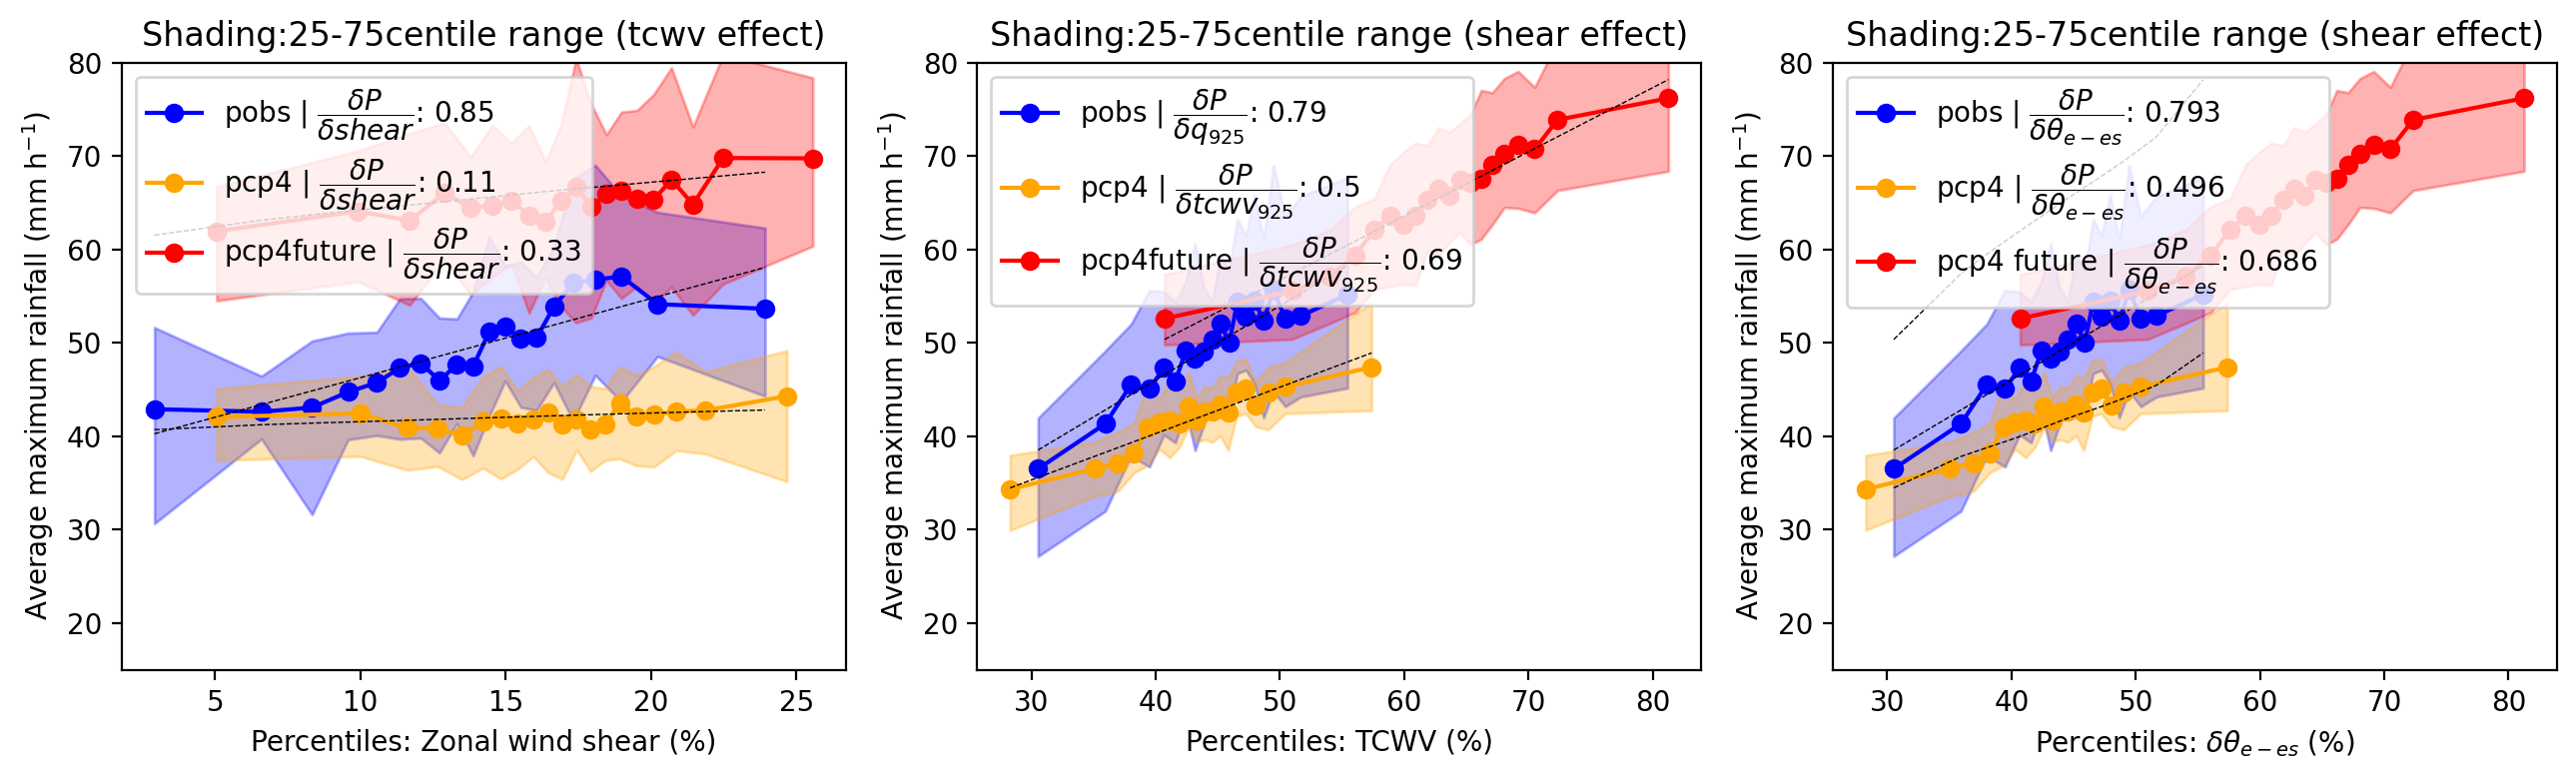

In [635]:
f = plt.figure(figsize=(13,4), dpi=200)

pobs = obs_tcwv_shear
pcp4 = cp4_tcwv_shear
pcp4f = cp4f_tcwv_shear
ax = f.add_subplot(131)
plt.plot(pobs['rbins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['rslope'],2)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label='pcp4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4['rslope'],2)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label='pcp4future | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4f['rslope'],2)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Percentiles: Zonal wind shear (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (tcwv effect)')
#plt.ylim(10,50)
plt.ylim(15,80)
plt.legend(loc='upper left')

         
# pobs = obs_shear_theta
# pcp4 = cp4_shear_theta
# pcp4f = cp4f_shear_theta
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'Percentiles: $\delta \theta _{e-es}$ (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,0)
plt.ylim(15,80)
plt.legend(loc='upper left')

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['rslope'],2)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['rslope'],2)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['rslope'],2)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,80)
plt.ylim(15,80)
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatterOrig_'+tag+'_OBS_CP4futureavg_'+ttag+'_perc.png')

Percentage mean 2.9161050994024498


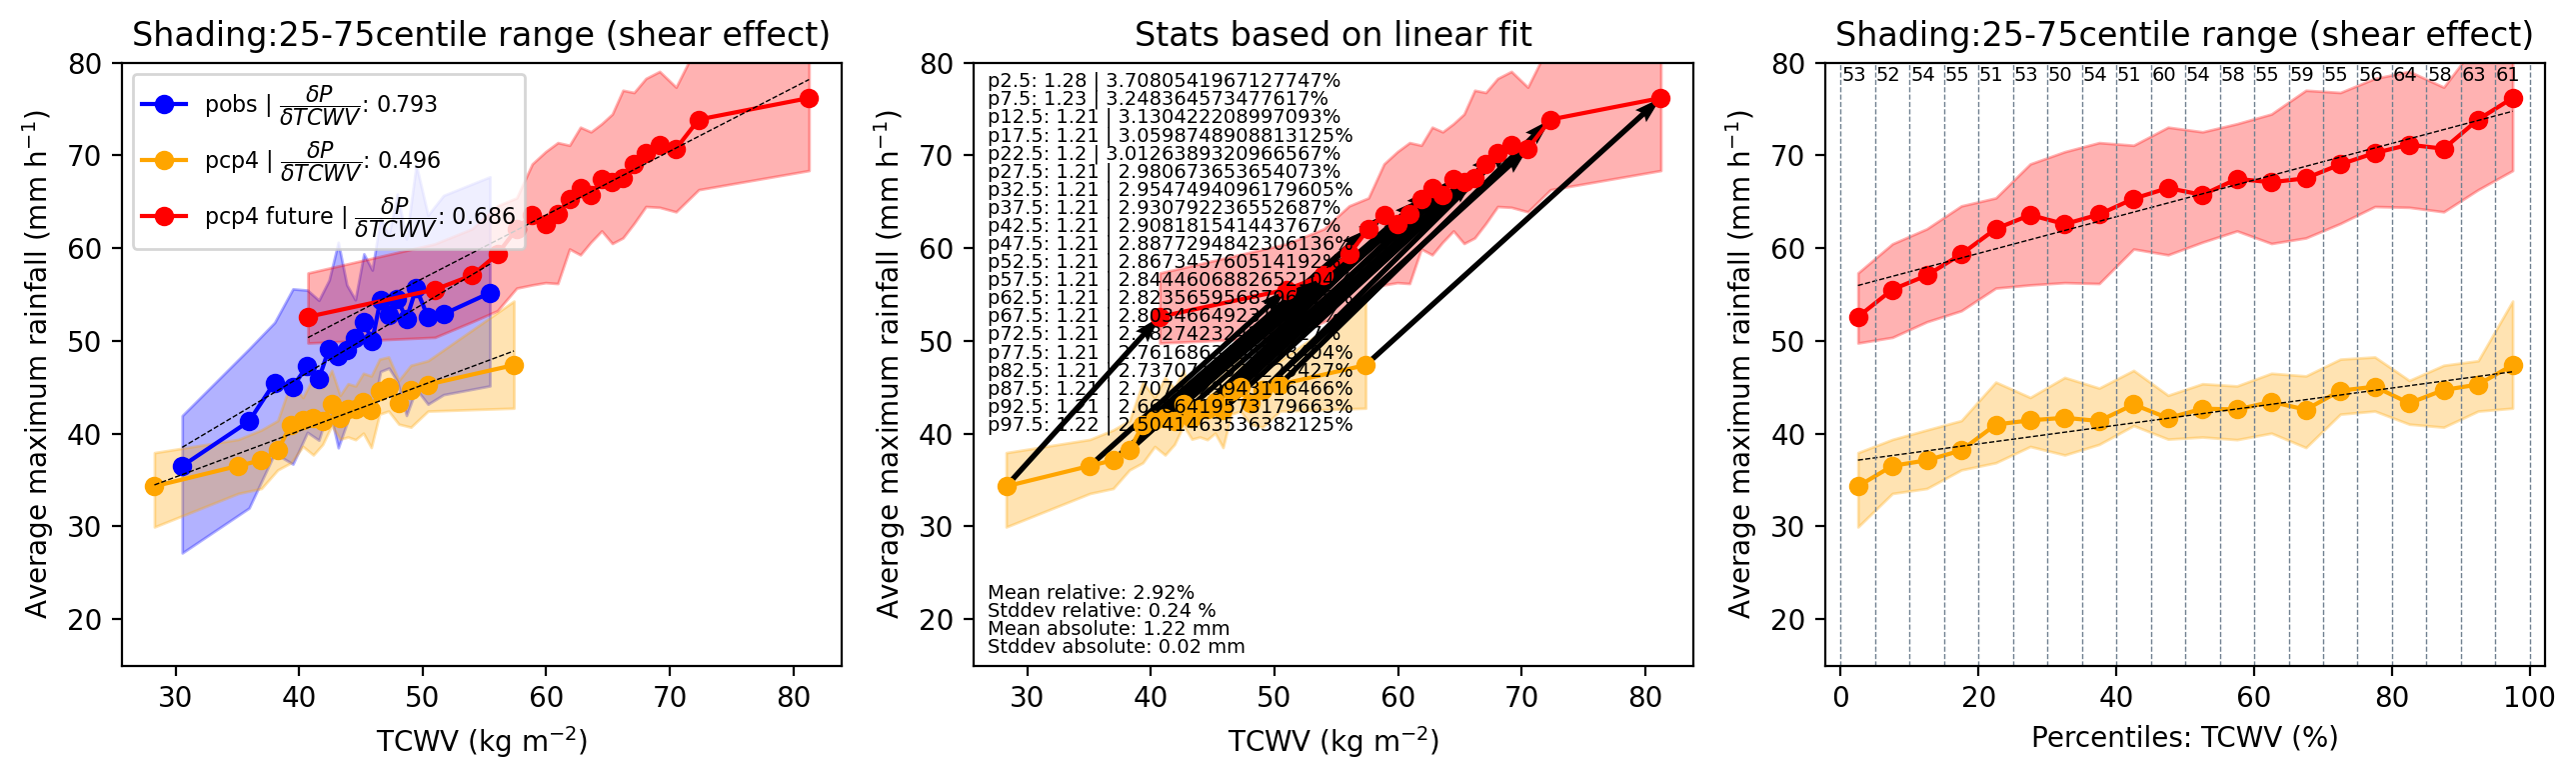

In [636]:
percmid = np.arange(0,101,5)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

f = plt.figure(figsize=(13,4), dpi=200)

         
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(131)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pobs['rslope'],3)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,0)
plt.ylim(15,80)
plt.legend(loc='upper left', fontsize=8)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'], pcp4['pmean'],(pcp4f['rbins']-pcp4['rbins']),np.array((pcp4f['pmean'])-np.array(pcp4['pmean'])), angles='xy', scale_units='xy', scale=1)

coll = []
abss = []

for ids, percs in enumerate(percents):
    #ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    
    ppabs = (np.array(((pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])[ids])-np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    
    pperc = ppabs / (pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]*100
    plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(pperc)+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage mean', np.mean(coll))

plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Stats based on linear fit')
#plt.ylim(10,0)
plt.ylim(15,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
allrel = []
allabs = []
for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 78,str(ttext), fontsize=7)
        allrel.append(ttext)
        allabs.append((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids]))
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,80)
plt.ylim(15,80)
#plt.legend(loc='upper left')
plt.ylim(15,80)


plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_linfit_'+ttag+'.png')

In [637]:
print(np.mean(allrel))
print(np.std(allrel))

55.8
3.9064049969249224


In [638]:
print(np.mean(allabs))
print(np.std(allabs))

23.456580603767932
2.9326935040329745


In [639]:
yposis = []
yposisf = []
xposis = []
xposisf = []
for rb, rbf in zip(pcp4['rbins'],pcp4f['rbins']):
    yposi = np.nanargmin(np.abs(rb-cp4_basic['xbins']))
    yfposi = np.nanargmin(np.abs(rbf-cp4f_basic['xbins']))
    
    xposi = (cp4_basic['nb']/np.sum(cp4_basic['nb']))[yposi]
    xfposi = (cp4f_basic['nb']/np.sum(cp4f_basic['nb']))[yfposi]
    
#     ipdb.set_trace()

#     pos = np.where(yposis == xposi)
#     if np.sum(np.isfinite(pos)) != 0:
#             xposi = (cp4_basic['nb']/np.sum(cp4_basic['nb']))[yposi+1]

    xposis.append((cp4_basic['xbins'])[yposi])
    xposisf.append((cp4f_basic['xbins'])[yfposi])
    yposis.append(xposi)
    yposisf.append(xfposi)

In [640]:
yposis = np.array(yposis)
yposisf = np.array(yposisf)
xposis = np.array(xposis)
xposisf=np.array(xposisf)

In [641]:
percmid = np.arange(0,101,5)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

Percentage median 2.8519455243725482


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


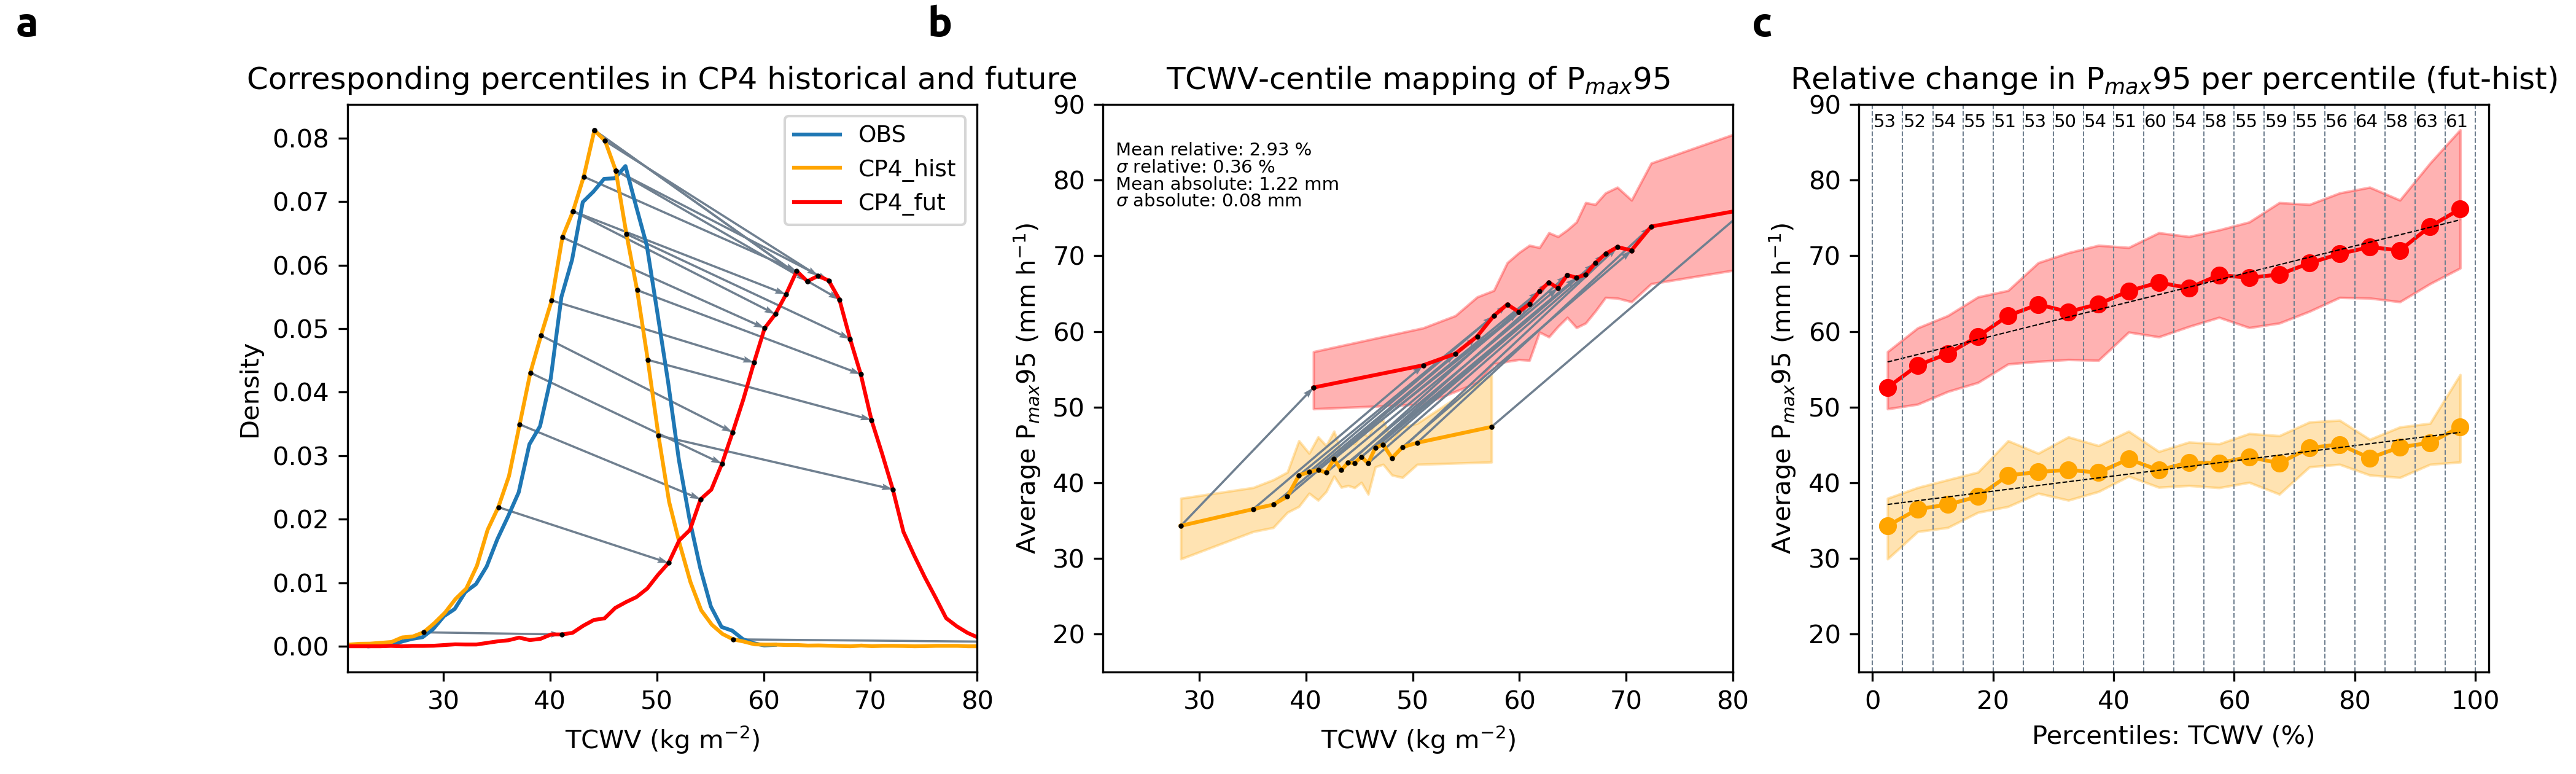

In [642]:


f = plt.figure(figsize=(15,4), dpi=300)

         
ax = f.add_subplot(131)
plt.plot(obs_basic['xbins'], obs_basic['nb']/np.sum(obs_basic['nb']), label='OBS')
plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='red', label='CP4_fut')
plt.quiver(xposis, yposis,xposisf-xposis,yposisf-yposis, angles='xy', scale_units='xy', scale=1,  width=0.0035, color='slategrey')
plt.plot(xposis, yposis, marker='o', linestyle='none', markersize=1, color='k')
plt.plot(xposisf, yposisf, marker='o', linestyle='none', markersize=1, color='k')
plt.ylabel('Density')
plt.xlabel('TCWV (kg m$^{-2}$)')
plt.legend(loc='upper right', fontsize=9)
plt.title('Corresponding percentiles in CP4 historical and future')
plt.xlim(21,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', markersize=1, label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', marker='o', markersize=1, label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=1)
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=1)
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'], pcp4['pmean'],(pcp4f['rbins']-pcp4['rbins']),np.array((pcp4f['pmean'])-np.array(pcp4['pmean'])), angles='xy', scale_units='xy', scale=1, color='slategrey', width=0.0035)
plt.xlim(21,80)
coll = []
abss = []

for ids, percs in enumerate(percents):
    ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    
    pppabs = (np.array(((pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])[ids])-np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    #ipdb.set_trace()
    pperc = (ppabs / pcp4['pmean'][ids])*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.91,'Mean relative: '+str(np.round(np.mean(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.88,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.85,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.82,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('TCWV-centile mapping of P$_{max}$95')
#plt.ylim(10,0)
plt.ylim(15,90)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 87,str(ttext), fontsize=7)
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
#plt.ylim(10,80)
plt.ylim(15,90)
#plt.legend(loc='upper left')
plt.ylim(15,90)

text = ['a', 'b', 'c']
plt.annotate(text[0], xy=(0.006, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_d.png')

In [643]:
30*0.74

22.2

No handles with labels found to put in legend.


Percentage median 2.8519455243725482


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


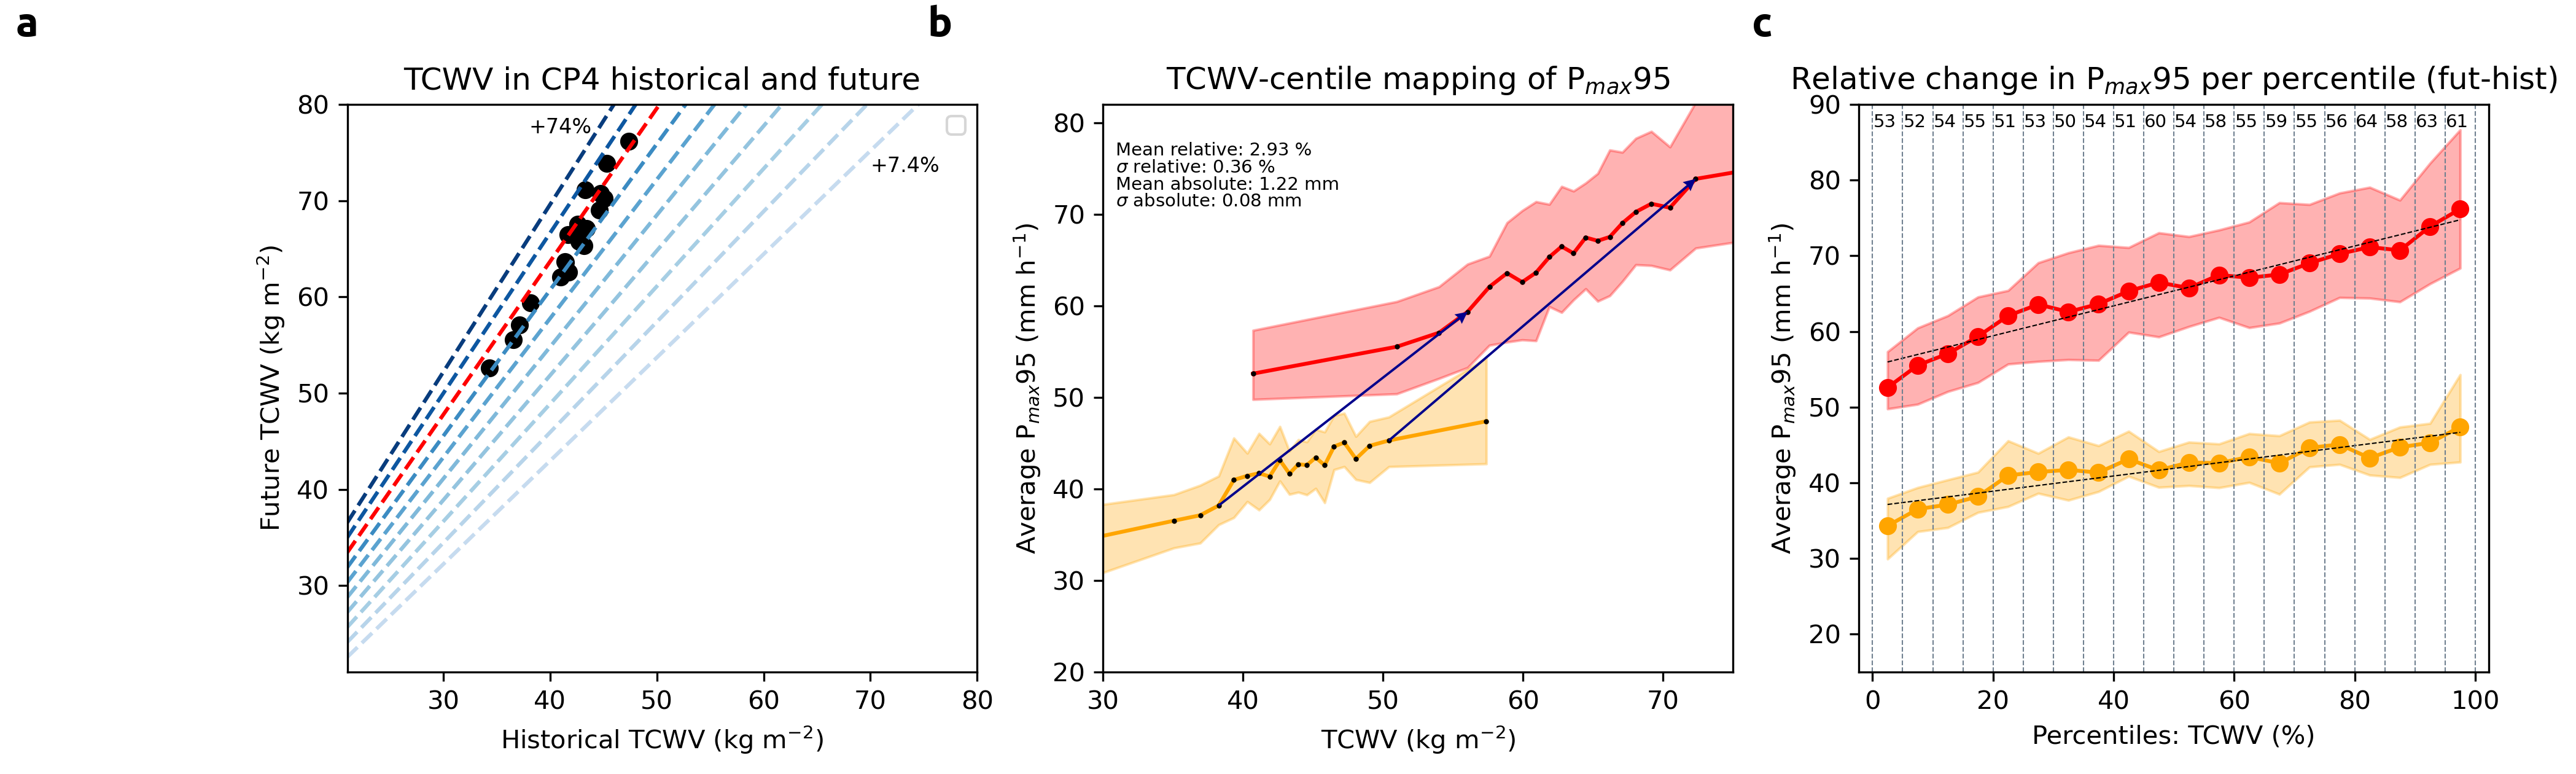

In [644]:
f = plt.figure(figsize=(15,4), dpi=300)

         
ax = f.add_subplot(131)
plt.scatter(pcp4['pmean'],pcp4f['pmean'], color='k')
cmap=plt.get_cmap("Blues")
plt.plot(np.arange(21,80), np.arange(21,80)+0.074*np.arange(21,80), color=cmap(0.25), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+2*0.074*np.arange(21,80), color=cmap(0.3), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+3*0.074*np.arange(21,80), color=cmap(0.35), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+4*0.074*np.arange(21,80), color=cmap(0.4), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+5*0.074*np.arange(21,80), color=cmap(0.45), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+6*0.074*np.arange(21,80), color=cmap(0.55), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+7*0.074*np.arange(21,80), color=cmap(0.65), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+8*0.074*np.arange(21,80), color='red', linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+9*0.074*np.arange(21,80), color=cmap(0.85), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+10*0.074*np.arange(21,80), color=cmap(0.95), linestyle='dashed')
plt.text(70,73,'+7.4%', fontsize=8)
plt.text(38,77,'+74%', fontsize=8)
plt.ylabel('Future TCWV (kg m$^{-2}$)')
plt.xlabel('Historical TCWV (kg m$^{-2}$)')
plt.legend(loc='upper right', fontsize=9)
plt.title('TCWV in CP4 historical and future')
plt.xlim(21,80)
plt.ylim(21,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', markersize=1, label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', marker='o', markersize=1, label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=1)
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=1)
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'][3::15], pcp4['pmean'][3::15],(pcp4f['rbins']-pcp4['rbins'])[3::15],np.array((pcp4f['pmean'])-np.array(pcp4['pmean']))[3::15], angles='xy', scale_units='xy', scale=1, color='darkblue', width=0.0038, zorder=99, headwidth=5)
plt.xlim(30,75)
coll = []
abss = []

for ids, percs in enumerate(percents):
    ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    pperc = (ppabs / pcp4['pmean'][ids])*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.91,'Mean relative: '+str(np.round(np.mean(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.88,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.85,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.82,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('TCWV-centile mapping of P$_{max}$95')
#plt.ylim(10,0)
plt.ylim(20,82)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)

for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 87,str(ttext), fontsize=7)
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
#plt.ylim(10,80)
plt.ylim(15,90)
#plt.legend(loc='upper left')
plt.ylim(15,90)

text = ['a', 'b', 'c']
plt.annotate(text[0], xy=(0.006, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_d.png')

In [645]:
np.array(pcp4f['pmean'])-np.array(pcp4['pmean'])

array([18.27680942, 19.00684405, 19.94132257, 21.15590051, 21.09934348,
       22.1398786 , 20.8817814 , 22.2682562 , 22.18987955, 24.80813901,
       23.04585306, 24.85822834, 23.6748238 , 24.94333058, 24.3991994 ,
       25.19370244, 27.87066079, 26.01065239, 28.57411038, 28.79289611])

In [646]:
np.mean(np.array(pcp4f['pmean'])-np.array(pcp4['pmean']))

23.456580603767932

In [647]:
pcp4f['pmean']/pcp4f['rbins']

array([1.29203359, 1.08939945, 1.05684641, 1.05910333, 1.07781665,
       1.08018368, 1.04430004, 1.04436158, 1.05583981, 1.05934606,
       1.03350281, 1.0463729 , 1.02702551, 1.0201695 , 1.02886837,
       1.03236965, 1.0287281 , 1.00315575, 1.02116096, 0.93747765])

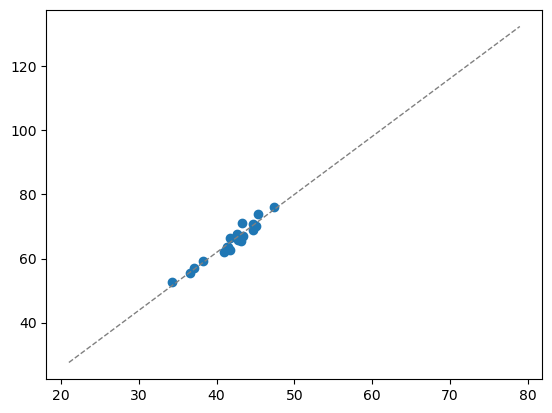

In [648]:
btc, atc, r_value, p_value, std_err = linregress(pcp4['pmean'],pcp4f['pmean'])
plt.scatter(pcp4['pmean'],pcp4f['pmean'])
plt.plot(np.arange(21,80), atc+np.arange(21,80)*btc, color='grey', linestyle='dashed', linewidth=1)

Percentage median 2.8775376223724027
Percentage abs  1.2109385546536868


Text(0, 4, 'b')

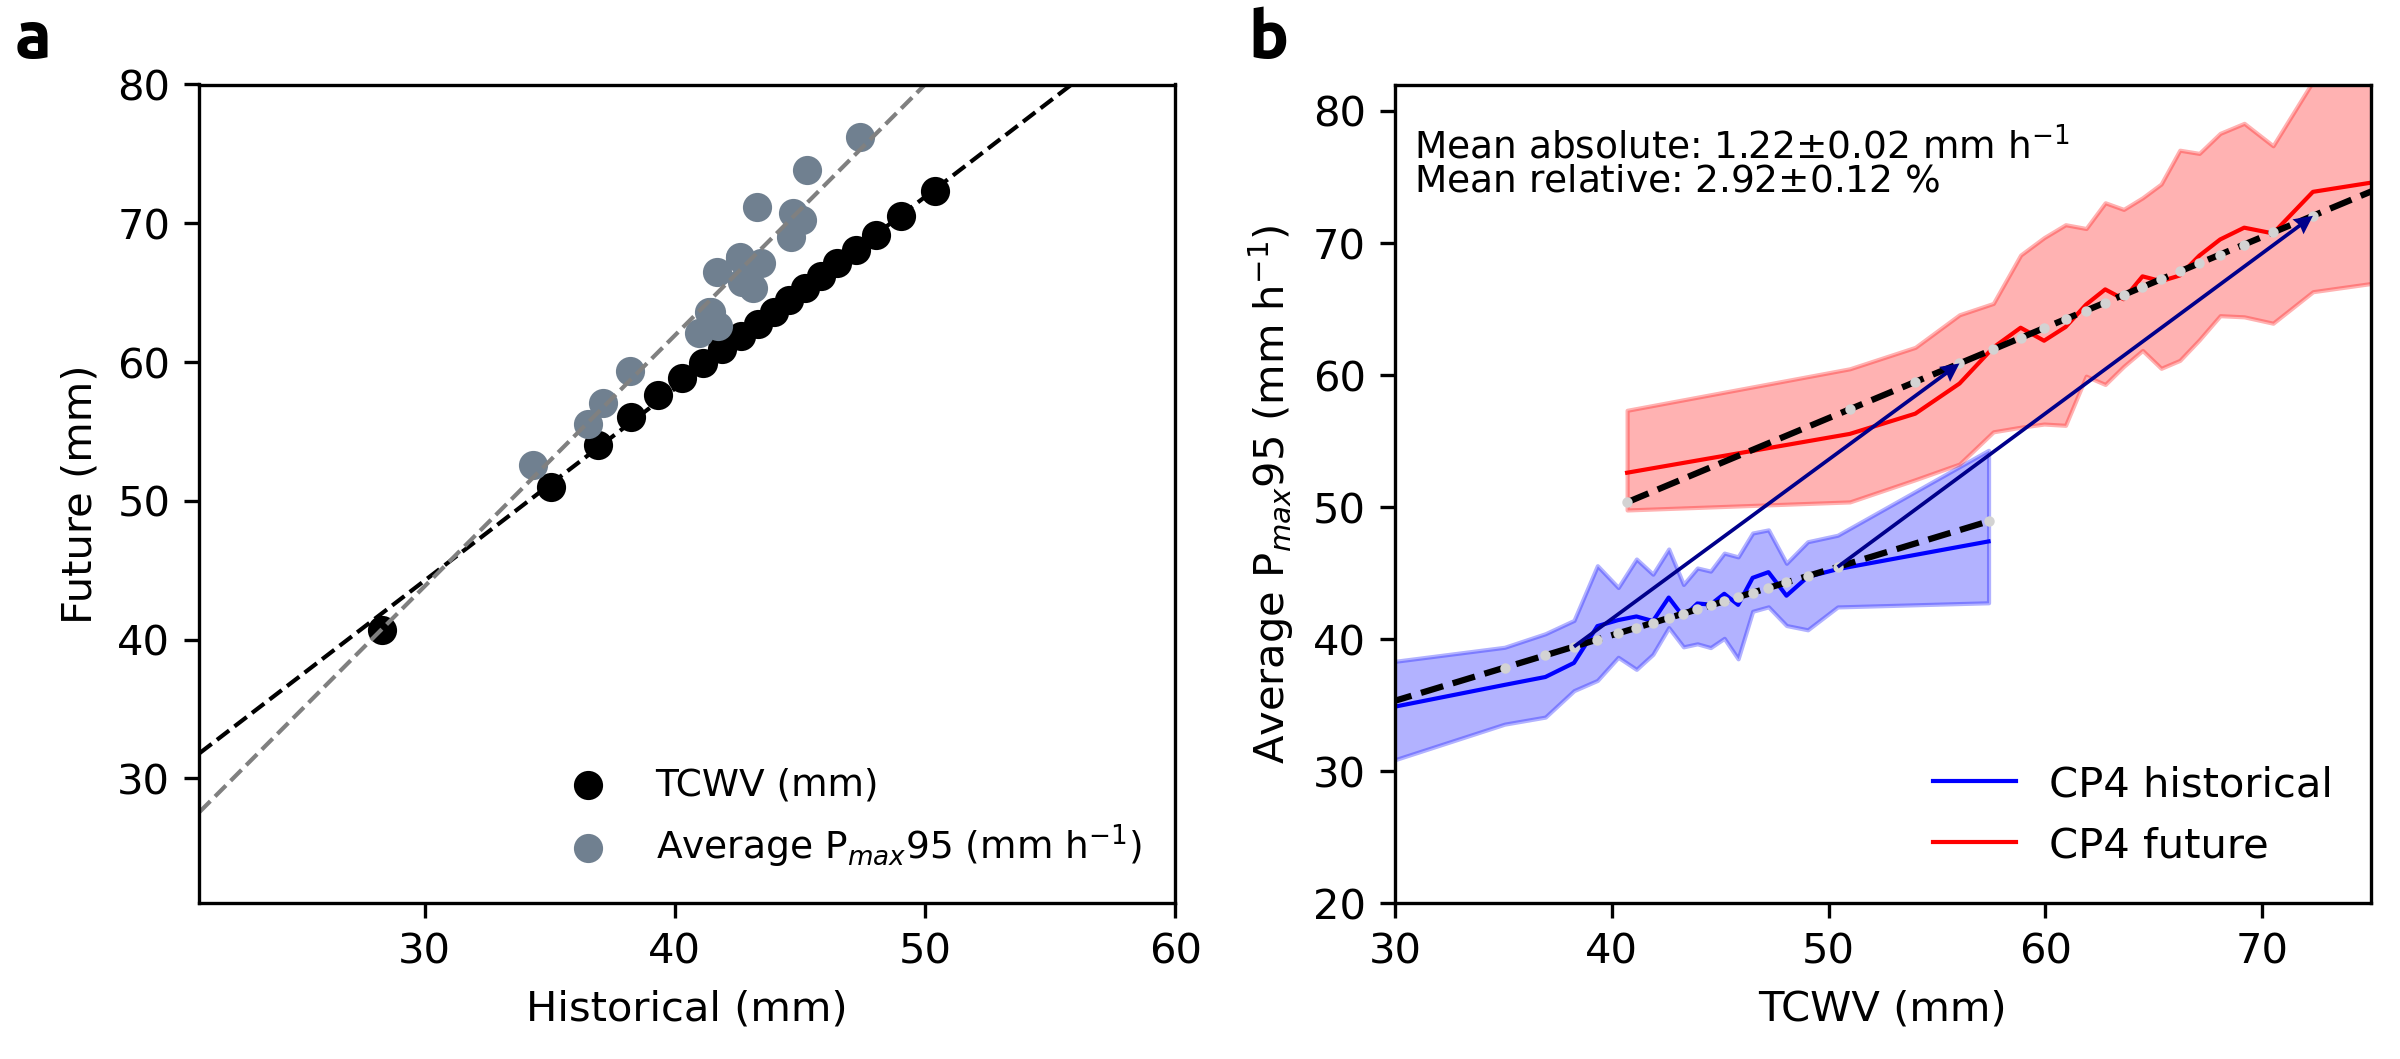

In [649]:
f = plt.figure(figsize=(8,3.5), dpi=300)

ax = f.add_subplot(122)

plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='blue',  label=r'CP4 historical', linewidth=1)  #marker='o', markersize=1,
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linewidth=1) #, marker='o', markersize=1

histline = (pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])
futline = (pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

plt.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=1.5)
plt.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=1.5)
plt.plot(pcp4['rbins'],histline, color='lightgrey', marker='o',  markersize=1.5, linestyle='', linewidth=1.5)
plt.plot(pcp4f['rbins'], futline, color='lightgrey', marker='o', markersize=1.5, linestyle='', linewidth=1.5)

# plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=2)
# plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=2)

#plt.quiver(pcp4['rbins'][3::15], pcp4['pmean'][3::15],(pcp4f['rbins']-pcp4['rbins'])[3::15],np.array((pcp4f['pmean'])-np.array(pcp4['pmean']))[3::15], angles='xy', scale_units='xy', scale=1, color='darkblue', width=0.0038, zorder=99, headwidth=5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'][3::15], np.array(histline)[3::15],(pcp4f['rbins']-pcp4['rbins'])[3::15],(np.array(futline)-np.array(histline))[3::15], angles='xy', scale_units='xy', scale=1, color='darkblue', width=0.0038, zorder=99, headwidth=5)

plt.xlim(30,75)
plt.legend(loc='lower right', frameon=False)
coll = []
abss = []

for ids, percs in enumerate(percents):
    #ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    #linfit
    ppabs = (np.array(((pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])[ids])-np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
  
    #pperc = (ppabs / pcp4['pmean'][ids])*100
    #linfit
    pperc = ppabs / (pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.87,r'Mean relative: '+str(np.round(np.mean(coll),2))+'$\pm$'+str(np.round(np.std(coll)/2,2))+' %', transform=ax.transAxes, fontsize=9) # 0.83
#plt.text(0.02, 0.79,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=9)
plt.text(0.02, 0.91,r'Mean absolute: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=9)
#plt.text(0.02, 0.87,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=9)

plt.xlabel(r'TCWV (mm)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

plt.ylim(20,82)

ax = f.add_subplot(121)
plt.scatter(pcp4['rbins'],pcp4f['rbins'], color='k', label='TCWV (mm)') #pmean
plt.scatter(pcp4['pmean'],pcp4f['pmean'], color='slategrey', label='Average P$_{max}$95 (mm h$^{-1}$)')
cmap=plt.get_cmap("Reds")


b, a, r_value, p_value, std_err = linregress(pcp4['rbins'],pcp4f['rbins'])
btc, atc, r_value, p_value, std_err = linregress(pcp4['pmean'],pcp4f['pmean'])


pmax_increase = ((atc+np.arange(21,80)*btc)-np.arange(21,80))/np.arange(21,80)
tc_increase = ((a+np.arange(21,80)*b)-np.arange(21,80))/np.arange(21,80)
#print('TCW hist/fut slope', tc_increase)
#print('Pmax percentage increase hist/fut', pmax_increase)
#print('TCW percentage increase hist/fut', tc_increase)
#print('Pmax percentage increase hist/fut', pmax_increase)
#print('increase ratio', pmax_increase/tc_increase)

precip_ratio = np.round(np.mean( (np.arange(21,80)*btc+atc)/ (np.arange(21,80)*b + a) ) , 2)
#print('Precip ratio', precip_ratio)


plt.plot(np.arange(21,80), a+np.arange(21,80)*b, color='k', linestyle='dashed', linewidth=1)
plt.plot(np.arange(21,80), atc+np.arange(21,80)*btc, color='grey', linestyle='dashed', linewidth=1)
#plt.plot(np.arange(21,60), a*1.2+np.arange(21,60)*b*1.15, color='grey', linestyle='dashed', linewidth=1)


# plt.text(70,74,'+1K', fontsize=9)
# plt.text(36,77,'+10K', fontsize=9)
plt.ylabel('Future (mm)')
plt.xlabel('Historical (mm)')
plt.legend(loc='lower right', fontsize=9, frameon=False)
#plt.title('xCC(6.2% K$^{-1}$)$_{Pmax95}$: ' +str(cc_assumed) + r' || $\frac{\Delta TCW}{\Delta T2m}_{CP4}$: '+str(np.round(cc*100,2))+'% K$^{-1}$ ; Scaling$_{ratio}$'+ r'$\frac{Pmax95}{TCW}$: ' +str(precip_ratio), fontsize=8 ) #+str(total_pscaling)+'% K$^{-1}$' , fontsize=8)
#plt.title('Scaling$_{ratio}$'+ r'$\frac{Pmax95}{TCW}$: ' +str(precip_ratio), fontsize=8 )
#plt.text(0.02, 0.91,'Scaling$_{ratio}$'+ r'$\frac{Pmax95}{TCW}$: ' +str(precip_ratio), fontsize=9, transform=ax.transAxes) # 0.83
plt.xlim(21,60)
plt.ylim(21,80)

# ax11 = ax.twiny()
# ax11.plot()


pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv

# ax = f.add_subplot(133)
# #plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
# #plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
# plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
# plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
# plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
# plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
# #plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# for ids, pp in enumerate(np.arange(0,101,5)):
#     plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
#     try:
#         ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
#         plt.text(pp+0.1, 87,str(ttext), fontsize=7)
#     except:
#         pass

# plt.xlabel('Percentiles: TCWV (%)')
# plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
# plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
# #plt.ylim(10,80)
# plt.ylim(15,90)
# #plt.legend(loc='upper left')
# plt.ylim(15,90)

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_monthly.png')

In [650]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP.csv', index_col='model_name')

In [651]:
cmip_read

{'2030':                 Unnamed: 0  shear_mean  tcw_mean   tcw_hist  shear_hist
 model_name                                                             
 IPSL-CM5B-LR             0    0.912170  4.841961  33.911131   10.404154
 HadGEM2-CC               1    2.098358  6.906477  28.501823    9.269288
 GFDL-ESM2G               2    0.318918  5.276648  40.977561    9.495135
 IPSL-CM5A-MR             3    0.721732  6.478851  32.871407   11.931310
 CNRM-CM5                 4    0.297029  3.827699  38.742126   15.413859
 MPI-ESM-MR               5    0.761769  5.900804  40.279194   13.075834
 inmcm4                   6    0.511347  1.714728  34.446782   14.029803
 ACCESS1-0                7    1.923732  7.222635  31.470654    8.872770
 CSIRO-Mk3-6-0            8    0.481086  4.587815  45.425683   13.107189
 MIROC5                   9   -0.258663  6.207996  43.628927   16.020498
 bcc-csm1-1              10    0.332855  3.768188  36.149474   14.802469
 GISS-E2-H-CC            11    1.223998  5.

In [652]:
((cmip_read)['2080'])['tcw_mean']/((cmip_read)['2080'])['tcw_hist']

model_name
IPSL-CM5B-LR      0.324525
HadGEM2-CC        0.613102
GFDL-ESM2G        0.300417
IPSL-CM5A-MR      0.567050
CNRM-CM5          0.299743
MPI-ESM-MR        0.379513
inmcm4            0.180681
ACCESS1-0         0.572456
CSIRO-Mk3-6-0     0.288441
MIROC5            0.337943
bcc-csm1-1        0.273557
GISS-E2-H-CC      0.279965
MRI-CGCM3         0.374569
NorESM1-M         0.410044
GFDL-CM3          0.609869
HadGEM2-ES        0.555215
MPI-ESM-LR        0.336746
IPSL-CM5A-LR      0.566451
CESM1-CAM5        0.311151
MIROC-ESM-CHEM    0.698388
CESM1-BGC         0.334695
MIROC-ESM         0.652984
BNU-ESM           0.526933
FIO-ESM           0.266355
ACCESS1-3         0.568818
CMCC-CESM         0.347414
CMCC-CM           0.409851
bcc-csm1-1-m      0.326981
CanESM2           0.433542
GISS-E2-R-CC      0.261721
MRI-ESM1          0.388587
NorESM1-ME        0.399615
GISS-E2-R         0.251272
GISS-E2-H         0.297280
CMCC-CMS          0.462945
GFDL-ESM2M        0.254907
FGOALS-g2        

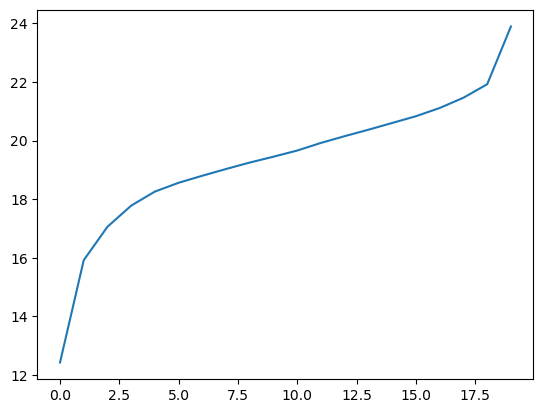

In [653]:
plt.plot((pcp4f['rbins']-pcp4['rbins']))

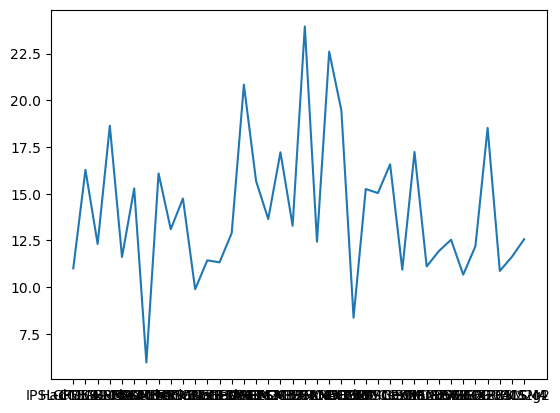

In [654]:
plt.plot((cmip_read['2080']['tcw_mean']))

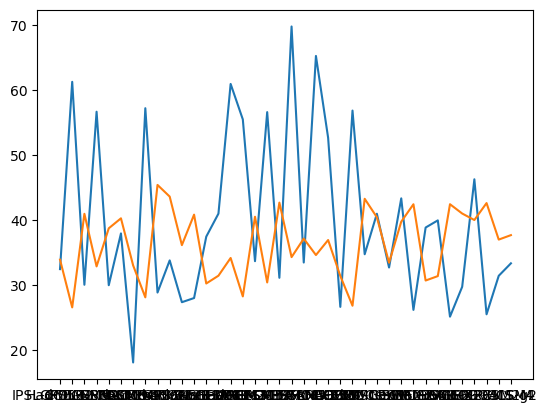

In [655]:
plt.plot((cmip_read['2080']['tcw_mean'])/(cmip_read['2080']['tcw_hist'])*100)
plt.plot((cmip_read['2080']['tcw_hist']))

In [656]:
np.mean(pcp4['rbins'])  # tcw mean from percentile mean

43.266

In [657]:
np.mean(cp4.tcwv) # tcw mean from MCS mean

43.21070030887553

In [658]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_domainMean = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY.csv', index_col=0)
    #ipdb.set_trace()
    cp4_domainMean['period'].append(dd)
    cp4_domainMean['shear'].append(np.array(dic.loc['shear'])*-1)
    cp4_domainMean['tcwv'].append(np.array(dic.loc['tcwv']))
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')
cp4_historical_domainMean = cp4_df.loc['CP4hist', 'tcwv']
cp4_future_domainMean = cp4_df.loc['CP4fut', 'tcwv']

In [659]:
cp4_historical_domainMean

array([40.219635])

In [660]:
cp4_future_domainMean-cp4_historical_domainMean

array([19.898422])

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Scaling per percentile [1.21153961 1.14583054 1.16296269 1.19185658 1.10917452 1.16007311
 1.09546043 1.1853091  1.13894869 1.32547751 1.20666992 1.30495387
 1.22251442 1.3176084  1.23383721 1.26747419 1.46585397 1.32938129
 1.4510043  1.45911276]
Percentage median 1.217027013835942
Percentage abs  1.1933893146509924


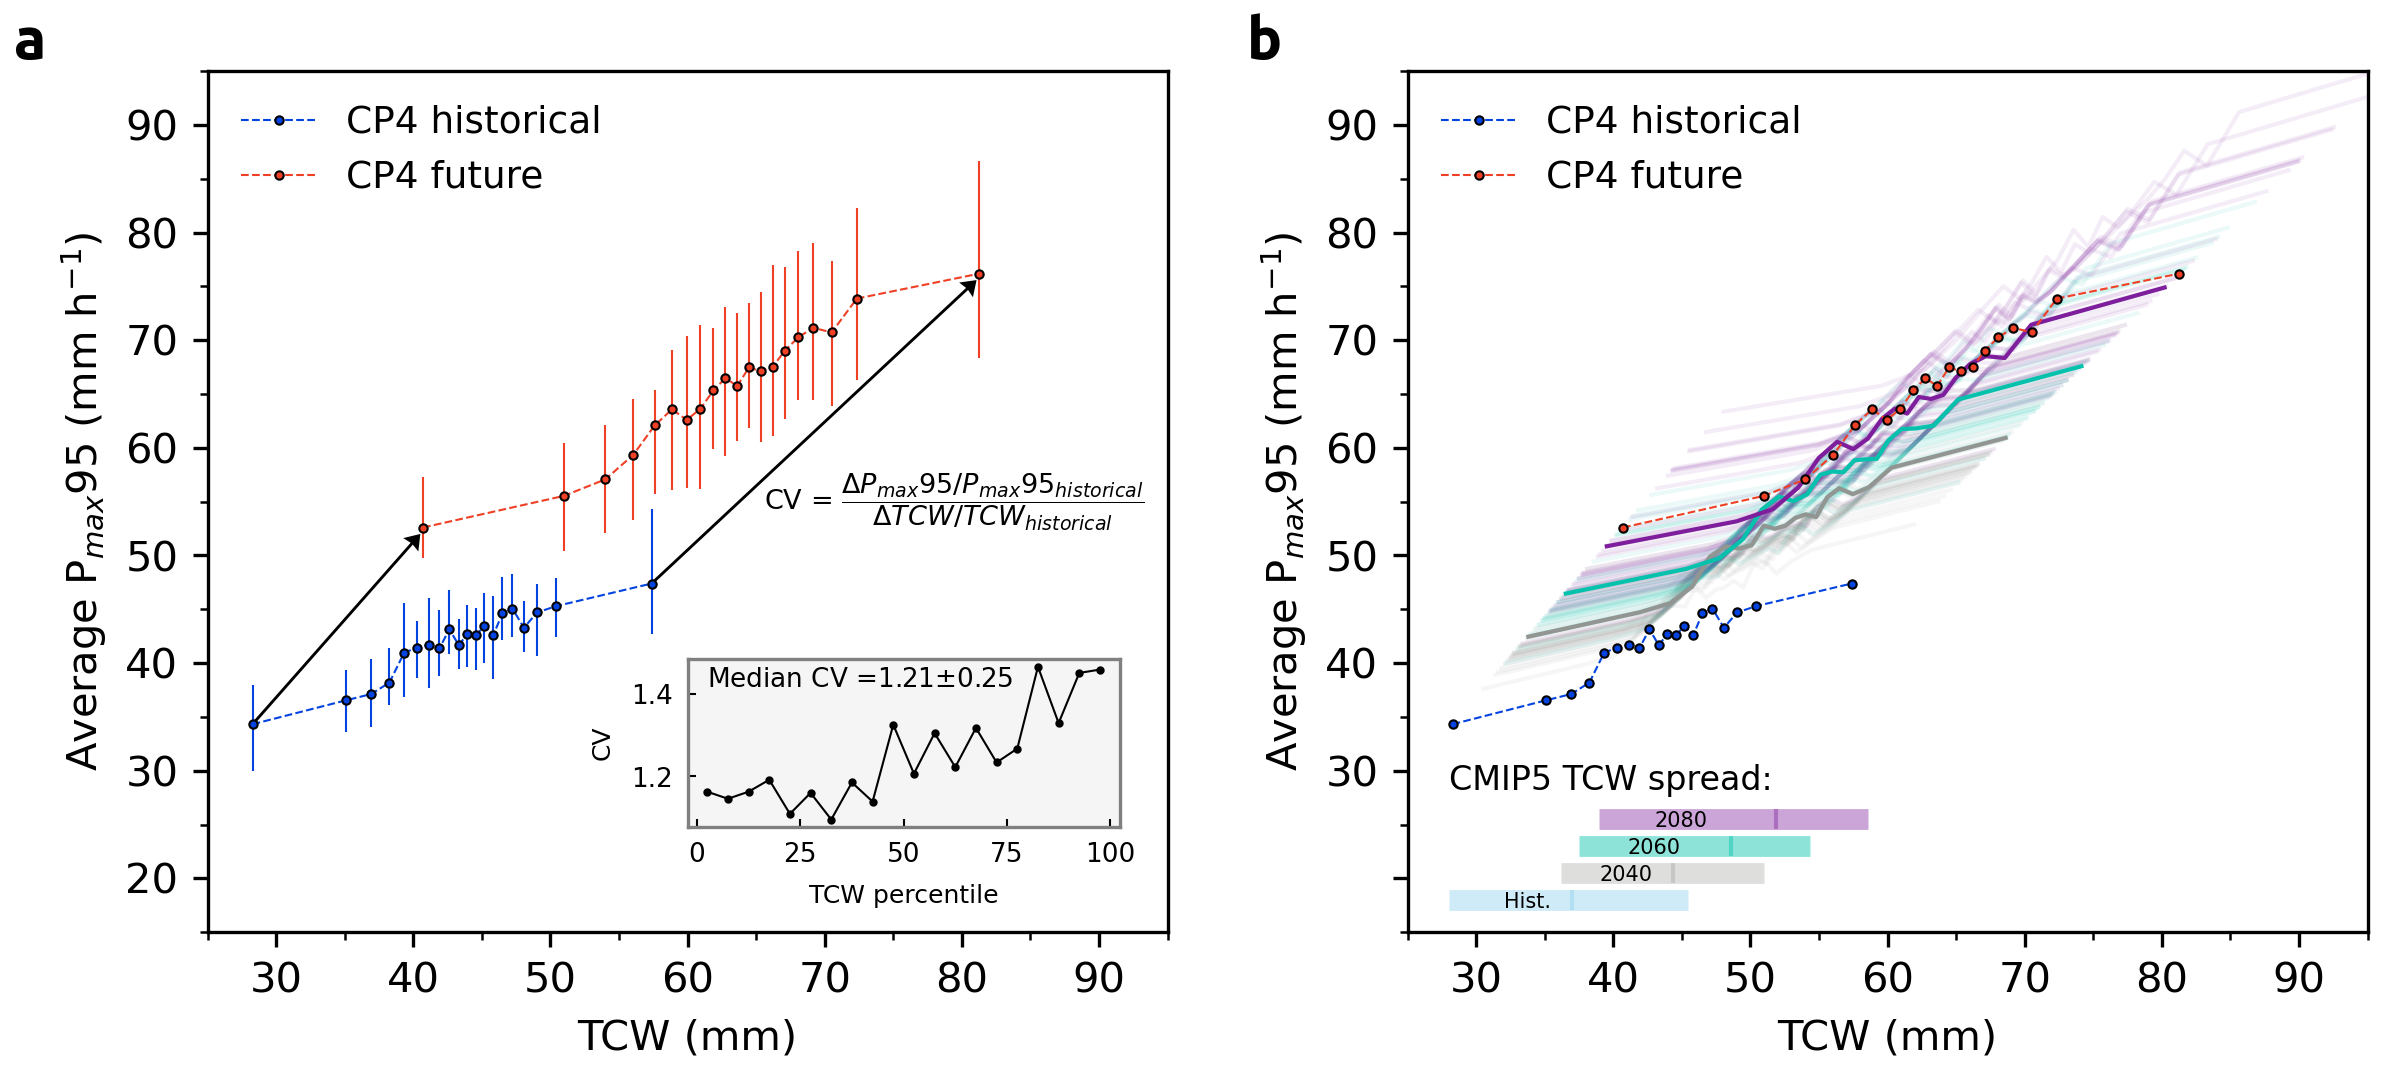

In [690]:
f = plt.figure(figsize=(8,3.5), dpi=300)
widthnorm = 0.40
heightnorm = 0.82
bottomnorm=0.13

left, bottom, width, height = [0.58, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [10.5,13,15.5]
alphas = [0.3,0.45,0.4]
ccolors = ['xkcd:grey', 'xkcd:turquoise', 'xkcd:purple']
dy = 10

#####
spread = ((cmip_read['2040'])['tcw_hist'])
mins = np.min(spread)
maxs = np.max(spread)
median = np.median(spread)
#ipdb.set_trace()
ax.errorbar(np.array(median), np.array(8+dy), xerr=np.array([[median-mins, maxs-median]]).T, color='skyblue', linewidth=5, alpha=0.4, linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)
idss=0
for ids, stry in enumerate(['2040', '2060', '2080']):
    idss += idss+1
    ##########
    spread = ((cmip_read[stry])['tcw_mean'])+((cmip_read[stry])['tcw_hist'])
    mins = np.min(spread)
    maxs = np.max(spread)
    median = np.median(spread)
    #ipdb.set_trace()
    ax.errorbar(np.array(median), np.array(posis[ids]+dy), xerr=np.array([[median-mins, maxs-median]]).T, color=ccolors[ids], linewidth=5, alpha=alphas[ids], linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)

ax.spines['top'].set_visible(True)
ax.spines['top'].set_linewidth(0.8)


ax.text(28,18.25+dy,'CMIP5 TCW spread:', fontsize=8)
ax.text(32,7.25+dy,'Hist.', fontsize=5)
ax.text(39,9.75+dy,'2040', fontsize=5)
ax.text(41,12.25+dy,'2060', fontsize=5)
ax.text(43,14.75+dy,'2080', fontsize=5)
####

# ax.plot(pcp4['rbins'],pcp4['pmean'], color='mediumblue',  label=r'CP4 historical', linestyle='',marker='o', markersize=3)  #marker='o', markersize=1, #cornflowerblue
# ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linestyle='',marker='o', markersize=3) #, marker='o', markersize=1


histline = np.array(pcp4['pmean']) #np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept']))
futline = np.array(pcp4f['pmean']) #np.array(pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

ax.plot(pcp4['rbins'],histline, color='xkcd:blue', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 historical', mfc='xkcd:blue',  marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)
ax.plot(pcp4f['rbins'], futline, color='xkcd:tomato', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 future', mfc='xkcd:tomato', marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)


pick = np.array([0,-1])
ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticklabels(['','',30,40,50,60,70,80,90])
ax.legend(loc='upper left', frameon=False, fontsize=9)
coll = []
abss = []
collmm = []

for ids, percs in enumerate(percents):

    ppabs = (futline[ids]-histline[ids])/(pcp4f['rbins'][ids]-pcp4['rbins'][ids])

    aprcp = (futline[ids]-histline[ids])/histline[ids]
    btcw = (pcp4f['rbins'][ids]-pcp4['rbins'][ids])/pcp4['rbins'][ids]
    pperc = aprcp/btcw
    coll.append(pperc)

    abss.append(ppabs)
    
coll = np.array(coll)


        
print('Scaling per percentile', coll)
    
for yyinds, yy in enumerate(['2040', '2060', '2080']):
    cmip_rrel = []
    cmip_rel = (cmip_read[yy]['tcw_mean'])/(cmip_read[yy]['tcw_hist'])  #cp4_historical_domainMean #/np.mean(cp4.tcwv)# relative to average MCS tcw ; i.e. if this is the change that ocurrs relative to MCS baseline tcw / compares domain-wide aggregate to domain-wide aggregate
    for crbins in (cmip_read[yy]['tcw_mean']):
        cmip_rrel.append(crbins/np.array(pcp4['rbins']))
    
    cmip_rrel = np.array(cmip_rrel)
    #ipdb.set_trace()
        
    cmip_diff = (cmip_read[yy]['tcw_mean'])
 
    for cinds, cmip_di in enumerate(cmip_rel):
        cmipfut = np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*cmip_di
        cmean = histline+histline*(cmip_di)*coll
        ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

        
#     for cinds, cmip_di in enumerate(cmip_read[yy]['tcw_mean']):
#         cmipfut = np.array(pcp4['rbins'])+cmip_di
#         cmean = histline+np.array(coll)*(cmip_di) 
#         ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

    cmean = histline+histline*(np.mean(cmip_rel))*coll #

    ax.plot(np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*np.mean(cmip_rel), cmean, color=ccolors[yyinds], zorder=95, linewidth=1, alpha=1, markersize=2)
    
    #reconstructed CP4 RAINFALL
   # ax.plot(np.array(pcp4f['rbins']), histline+histline*((pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'])*coll, color='r', linewidth=2)
    
print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')


#####################################################################################################################
left, bottom, width, height = [0.08, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [79,81,83]
alphas = [0.3,0.45,0.6]


ax.plot(pcp4['rbins'],pcp4['pmean'], color='xkcd:blue',  label=r'CP4 historical', linestyle='dashed',marker='o', markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5)  #marker='o', markersize=1, #cornflowerblue
ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='xkcd:tomato', label=r'CP4 future', linestyle='dashed', marker='o',markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5) #, marker='o', markersize=1
ax.errorbar(pcp4['rbins'], pcp4['pmean'], yerr=[np.array(pcp4['pmean'])-np.array(pcp4['p10']),np.array(pcp4['p90'])-np.array(pcp4['pmean'])], color='xkcd:blue', linewidth=0.5, linestyle='')
ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], yerr=[np.array(pcp4f['pmean'])-np.array(pcp4f['p10']),np.array(pcp4f['p90'])-np.array(pcp4f['pmean'])], color='xkcd:tomato', linewidth=0.5, linestyle='')
pick = np.array([0,-1])

yh = (histline)[pick]
xh = pcp4['rbins'][pick]
yf = (futline)[pick]
xf = pcp4f['rbins'][pick]
ax.quiver(xh, yh,(xf)-xh-0.2,yf-yh-0.6, angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=0, headwidth=7, linestyle='dotted')

# ax.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
# ax.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)


ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.legend(loc='upper left', frameon=False, fontsize=9)
ax.text(0.58, 0.49,r'CV = $\dfrac{\Delta P_{max}95 / P_{max}95_{historical}}{\Delta TCW / TCW_{historical}}$', transform=ax.transAxes, fontsize=6.5) # 0.83



#ax.text(0.58, 0.41,r'$\dfrac{\delta P_{max} 95}{\delta TCW}$: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=6.5)

coll[0] = coll[2]
fdic = {'rel': coll, 'abs' : abss, 'futslope': pcp4f['rslope'], 'histslope' : pcp4['rslope'], 
        'futinter' : pcp4f['rintercept'], 'histinter' : pcp4['rintercept'], 'tcw_hist' : pcp4['rbins'], 'prcp_hist' :  pcp4['pmean']}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "wb"))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

left, bottom, width, height = [0.28, 0.23, 0.18, 0.16] #[0.275, 0.2, 0.20, 0.27]
ax3 = f.add_axes([left, bottom, width, height])
ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.text(0.52, 0.285,r'Median CV ='+str(np.round(np.median(coll),2))+'$\pm$'+str(np.round(np.max(coll)-np.median(coll),2)), transform=ax.transAxes, fontsize=6.3) # 0.83
ax3.set_xlabel('TCW percentile', fontsize=6)
ax3.set_ylabel('CV',fontsize=6)

# ax3.set_xticklabels('')
# ax3.set_yticklabels('')
# ax3.set_xlim(32,62)
# ax3.set_ylim(30,85)

for axis in ['top','bottom','left','right']:
  
  ax3.spines[axis].set_color('grey')
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)
ax3.tick_params(direction='in', length=2, width=0.5, colors='k', labelsize=6.3)
ax3.set_facecolor('whitesmoke')

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)


plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4_'+ttag+'_TCWV_CMIPscaling_relative_CMIP_9-19N_20masked_CV_8mm.jpg')

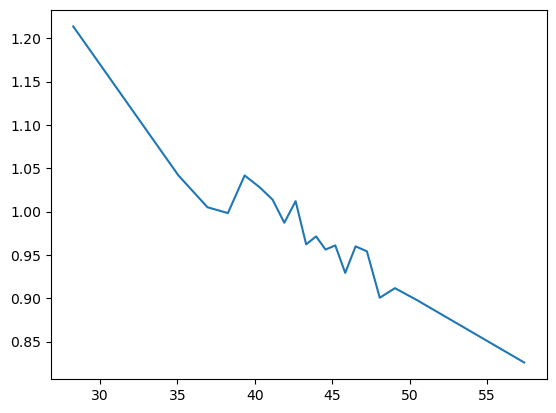

In [662]:
plt.plot(pcp4['rbins'],np.array(pcp4['pmean'])/np.array(pcp4['rbins']))  #np.array(pcp4['pmean'])

In [663]:
import matplotlib.style as style
style.use('default')

Scaling per percentile [1.21153961 1.14583054 1.16296269 1.19185658 1.10917452 1.16007311
 1.09546043 1.1853091  1.13894869 1.32547751 1.20666992 1.30495387
 1.22251442 1.3176084  1.23383721 1.26747419 1.46585397 1.32938129
 1.4510043  1.45911276]
Percentage median 1.217027013835942
Percentage abs  1.1933893146509924


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(0, 4, 'b')

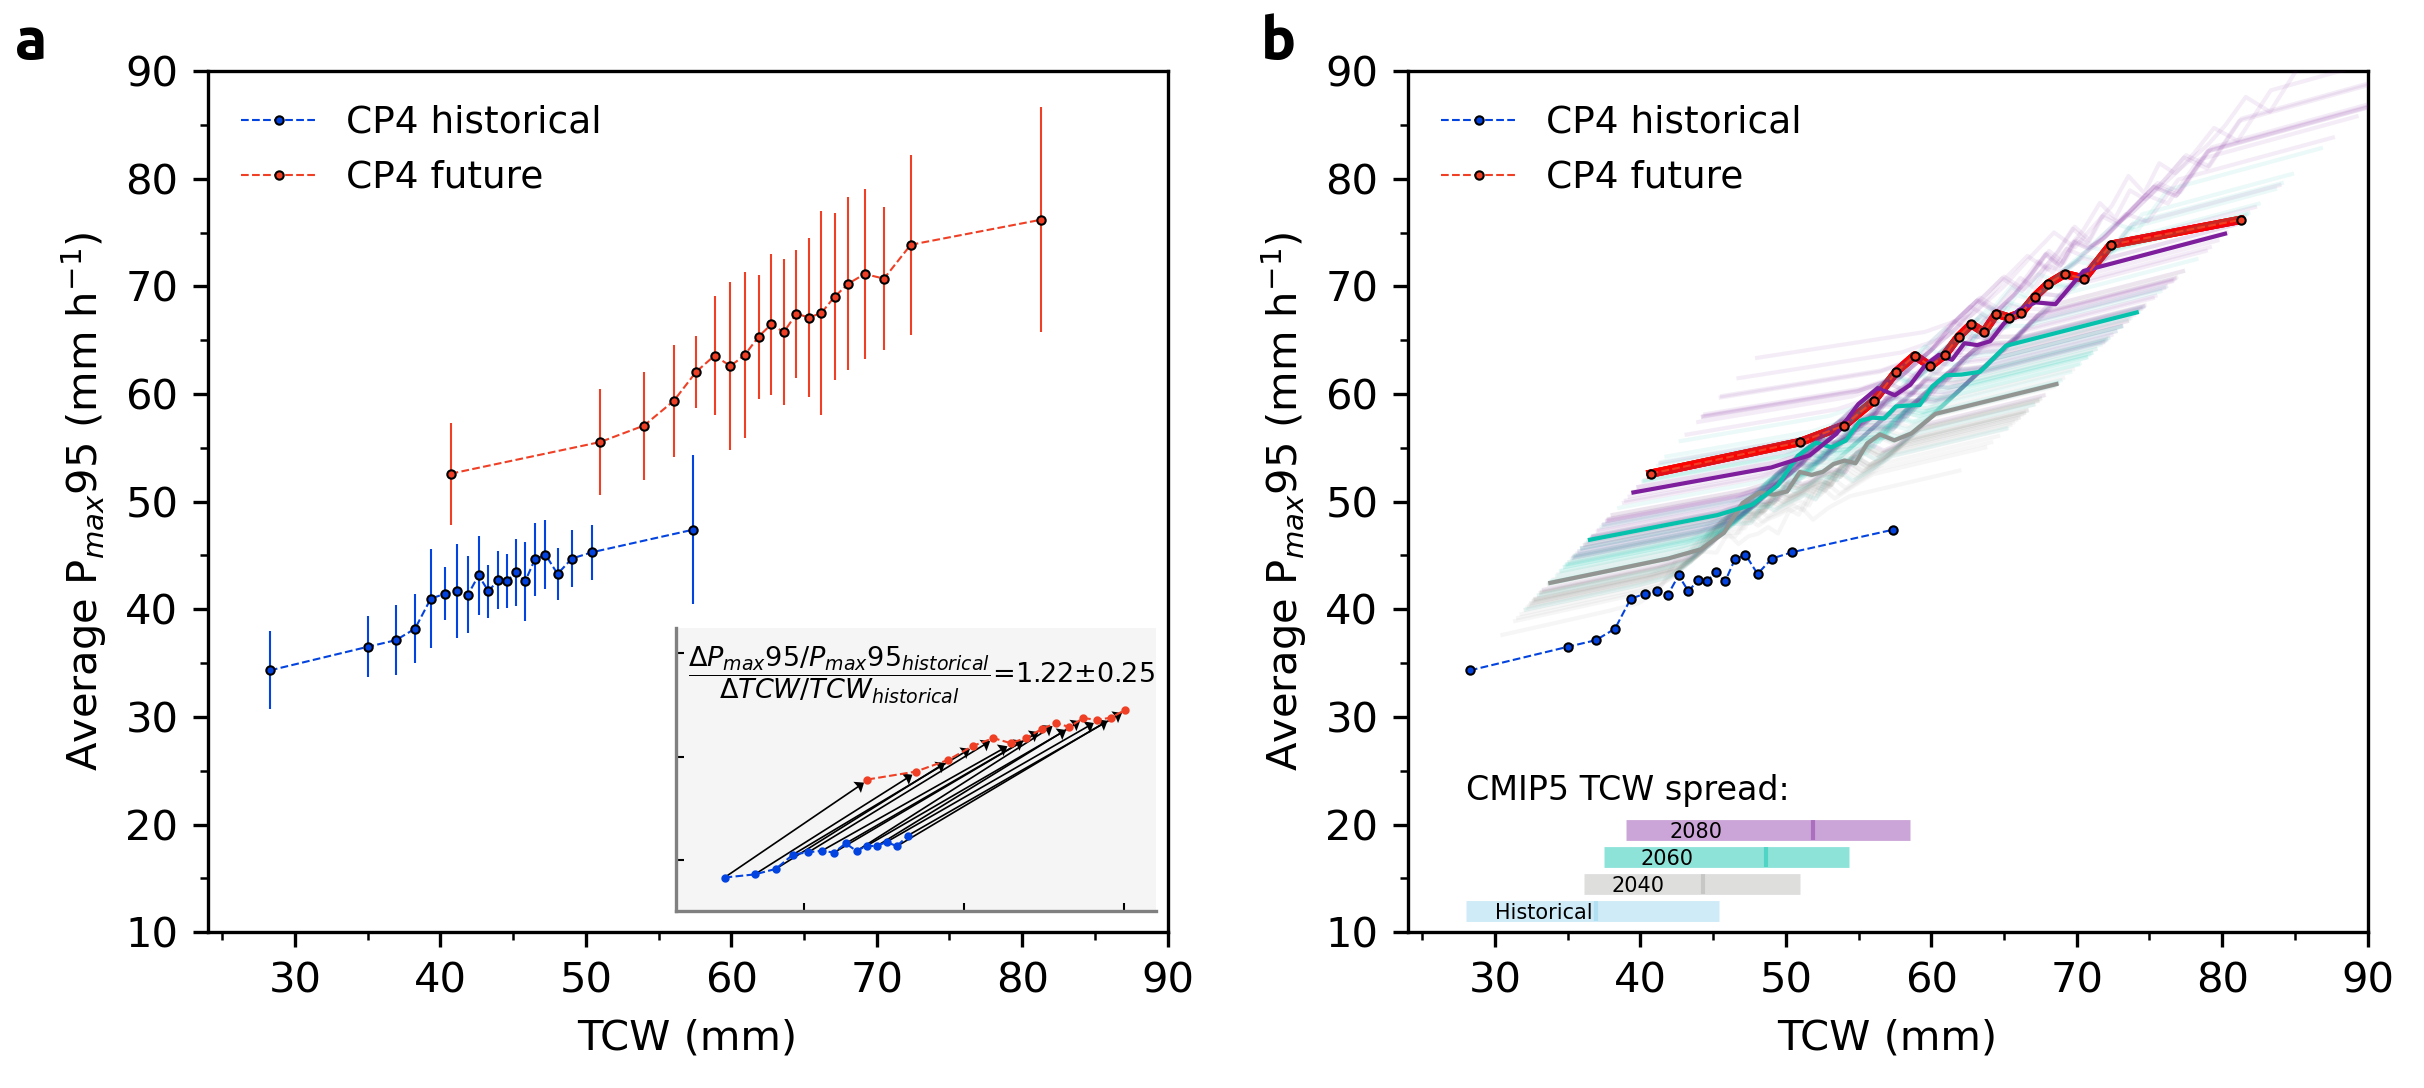

In [664]:
f = plt.figure(figsize=(8,3.5), dpi=300)
widthnorm = 0.40
heightnorm = 0.82
bottomnorm=0.13

left, bottom, width, height = [0.58, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [10.5,13,15.5]
alphas = [0.3,0.45,0.4]
ccolors = ['xkcd:grey', 'xkcd:turquoise', 'xkcd:purple']
dy = 4

#####
spread = ((cmip_read['2040'])['tcw_hist'])
mins = np.min(spread)
maxs = np.max(spread)
median = np.median(spread)
#ipdb.set_trace()
ax.errorbar(np.array(median), np.array(8+dy), xerr=np.array([[median-mins, maxs-median]]).T, color='skyblue', linewidth=5, alpha=0.4, linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)
idss=0
for ids, stry in enumerate(['2040', '2060', '2080']):
    idss += idss+1
    ##########
    spread = ((cmip_read[stry])['tcw_mean'])+((cmip_read[stry])['tcw_hist'])
    mins = np.min(spread)
    maxs = np.max(spread)
    median = np.median(spread)
    #ipdb.set_trace()
    ax.errorbar(np.array(median), np.array(posis[ids]+dy), xerr=np.array([[median-mins, maxs-median]]).T, color=ccolors[ids], linewidth=5, alpha=alphas[ids], linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)

ax.spines['top'].set_visible(True)
ax.spines['top'].set_linewidth(0.8)


ax.text(28,18.25+dy,'CMIP5 TCW spread:', fontsize=8)
ax.text(30,7.25+dy,'Historical', fontsize=5)
ax.text(38,9.75+dy,'2040', fontsize=5)
ax.text(40,12.25+dy,'2060', fontsize=5)
ax.text(42,14.75+dy,'2080', fontsize=5)
####

# ax.plot(pcp4['rbins'],pcp4['pmean'], color='mediumblue',  label=r'CP4 historical', linestyle='',marker='o', markersize=3)  #marker='o', markersize=1, #cornflowerblue
# ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linestyle='',marker='o', markersize=3) #, marker='o', markersize=1


histline = np.array(pcp4['pmean']) #np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept']))
futline = np.array(pcp4f['pmean']) #np.array(pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

ax.plot(pcp4['rbins'],histline, color='xkcd:blue', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 historical', mfc='xkcd:blue',  marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)
ax.plot(pcp4f['rbins'], futline, color='xkcd:tomato', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 future', mfc='xkcd:tomato', marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)


pick = np.array([0,-1])
ax.set_xlim(24,90)
ax.set_ylim(10,90)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.legend(loc='upper left', frameon=False, fontsize=9)
coll = []
abss = []
collmm = []

for ids, percs in enumerate(percents):

    ppabs = (futline[ids]-histline[ids])/(pcp4f['rbins'][ids]-pcp4['rbins'][ids])

    aprcp = (futline[ids]-histline[ids])/histline[ids]
    btcw = (pcp4f['rbins'][ids]-pcp4['rbins'][ids])/pcp4['rbins'][ids]
    pperc = aprcp/btcw
    coll.append(pperc)

    abss.append(ppabs)
    
coll = np.array(coll)
#coll[0] = coll[1]

        
print('Scaling per percentile', coll)
    
for yyinds, yy in enumerate(['2040', '2060', '2080']):
    cmip_rrel = []
    cmip_rel = (cmip_read[yy]['tcw_mean'])/(cmip_read[yy]['tcw_hist'])  #cp4_historical_domainMean #/np.mean(cp4.tcwv)# relative to average MCS tcw ; i.e. if this is the change that ocurrs relative to MCS baseline tcw / compares domain-wide aggregate to domain-wide aggregate
    for crbins in (cmip_read[yy]['tcw_mean']):
        cmip_rrel.append(crbins/np.array(pcp4['rbins']))
    
    cmip_rrel = np.array(cmip_rrel)
    #ipdb.set_trace()
        
    cmip_diff = (cmip_read[yy]['tcw_mean'])
 
    for cinds, cmip_di in enumerate(cmip_rel):
        cmipfut = np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*cmip_di
        cmean = histline+histline*(cmip_di)*coll
        ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

        
#     for cinds, cmip_di in enumerate(cmip_read[yy]['tcw_mean']):
#         cmipfut = np.array(pcp4['rbins'])+cmip_di
#         cmean = histline+np.array(coll)*(cmip_di) 
#         ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

    cmean = histline+histline*(np.mean(cmip_rel))*coll #

    ax.plot(np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*np.mean(cmip_rel), cmean, color=ccolors[yyinds], zorder=95, linewidth=1, alpha=1, markersize=2)
    
    #reconstructed CP4 RAINFALL
    ax.plot(np.array(pcp4f['rbins']), histline+histline*((pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'])*coll, color='r', linewidth=2)
    
print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

fdic = {'rel': coll, 'abs' : abss, 'futslope': pcp4f['rslope'], 'histslope' : pcp4['rslope'], 
        'futinter' : pcp4f['rintercept'], 'histinter' : pcp4['rintercept'], 'tcw_hist' : pcp4['rbins'], 'prcp_hist' :  pcp4['pmean']}
import pickle
#pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "wb"))


#####################################################################################################################
left, bottom, width, height = [0.08, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [79,81,83]
alphas = [0.3,0.45,0.6]


ax.plot(pcp4['rbins'],pcp4['pmean'], color='xkcd:blue',  label=r'CP4 historical', linestyle='dashed',marker='o', markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5)  #marker='o', markersize=1, #cornflowerblue
ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='xkcd:tomato', label=r'CP4 future', linestyle='dashed', marker='o',markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5) #, marker='o', markersize=1
ax.errorbar(pcp4['rbins'], pcp4['pmean'], yerr=np.array(pcp4['p90'])-np.array(pcp4['pmean']), color='xkcd:blue', linewidth=0.5, linestyle='')
ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], yerr=np.array(pcp4f['p90'])-np.array(pcp4f['pmean']), color='xkcd:tomato', linewidth=0.5, linestyle='')

# ax.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
# ax.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)

pick = np.array([0,-1])
ax.set_xlim(24,90)
ax.set_ylim(10,90)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.legend(loc='upper left', frameon=False, fontsize=9)


#ax.text(0.58, 0.41,r'$\dfrac{\delta P_{max} 95}{\delta TCW}$: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=6.5)

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

left, bottom, width, height = [0.275, 0.15, 0.20, 0.27]
ax3 = f.add_axes([left, bottom, width, height])

yh = (histline)[1:-5]
xh = pcp4['rbins'][1:-5]
yf = (futline)[1:-5]
xf = pcp4f['rbins'][1:-5]-7
ax3.plot(xh,yh, color='xkcd:blue', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
ax3.plot(xf, yf, color='xkcd:tomato', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
ax3.quiver(xh, yh,(xf)-xh-0.2,yf-yh-0.6, angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, zorder=0, headwidth=8, linestyle='dotted')
ax3.text(0.50, 0.29,r'$\dfrac{\Delta P_{max}95 / P_{max}95_{historical}}{\Delta TCW / TCW_{historical}}$='+str(np.round(np.median(coll),2))+'$\pm$'+str(np.round(np.max(coll)-np.median(coll),2)), transform=ax.transAxes, fontsize=6.5) # 0.83

ax3.set_xticklabels('')
ax3.set_yticklabels('')
ax3.set_xlim(32,62)
ax3.set_ylim(30,85)

for axis in ['top','bottom','left','right']:
  
  ax3.spines[axis].set_color('grey')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(direction='in', length=2, width=0.5, colors='k')
ax3.set_facecolor('whitesmoke')

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4_'+ttag+'_TCWV_CMIPscaling_relative_CMIP_9-19N_20masked.jpg')

In [665]:
def relate_climate(hist_tcw, fut_tcw):
    ddic = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))
    hist_pcp = ddic['histslope']*hist_tcw+ddic['histinter']
    fut_pcp = ddic['futslope']*fut_tcw+ddic['futinter']
    prel = (fut_pcp-hist_pcp)/hist_pcp * 100
    trel = (fut_tcw-hist_tcw)/hist_tcw * 100
    dic = {'hist_pcp' : hist_pcp, 'fut_pcp' : fut_pcp, 'rel_pchange' : prel, 'rel_tchange' : trel}

    return dic